# Lab 1: Gaia, RR Lyrae Stars, and Galactic Dust
<br>
Last updated: Fri Feb 23 9:59 PM, 2024

In [2]:
import corner
import io
import matplotlib
import os
import requests
import scipy.stats
import random
import time

import arviz as az
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from arviz import plot_trace as traceplot
from astropy import units as units
from astropy.table import Table
from astropy.timeseries import LombScargle
from astroquery.gaia import Gaia
from astroquery.utils.tap.core import TapPlus
from sklearn.model_selection import train_test_split

from IPython.display import display, HTML
from joblib import Memory

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set_context("poster")
sns.set_style("whitegrid")

In [4]:
### FUNCTIONS ###

## DATA RETRIEVAL ##

# cache directory for gaia queries
cachedir_query = './joblib_cache_gaia_query'
# 1e7 nytes (10 MB)
memory_query = Memory(
    cachedir_query, 
    verbose=0, 
    bytes_limit=1e7
)

@memory_query.cache
def get_gaia_query(q):
    """
    Submits an ADQL query to the
    Gaia archive to retrieve and
    store data in an astropy
    table.
    """
    start = time.time() # track time to carry out job
    job = Gaia.launch_job_async(q)
    print(f"Total time: {time.time()-start:0.2f} sec")
    return job.get_results()

def get_datalink(
    table, 
    data_release='Gaia DR3', 
    retrieval_type='EPOCH_PHOTOMETRY', 
    data_structure='COMBINED'
):
    """
    Download raw light curves from datalink 
    with corresponding source ids in a Gaia query 
    and store them in an Astropy table.
    
    INPUTS:
        table: Astropy table constructed 
            from ADQL query of Gaia archive.
        data_release: Data release version, 
            default is 'Gaia DR3'.
        retrieval_type: Type of retrieval, 
            default is 'EPOCH_PHOTOMETRY'.
        data_structure: Structure of data, 
            default is 'COMBINED'.
        
    OUTPUT:
        Astropy data table containing downloaded data.
    """
    # Retrieve datalink
    datalink = Gaia.load_data(
        ids=table['source_id'],
        data_release=data_release,
        retrieval_type=retrieval_type,
        data_structure=data_structure,
        verbose=False,
        output_file=None
    )
    
    # Get available data product keys
    dl_product_keys = sorted(datalink.keys())
    
    # Choose the first key as default
    selected_dl_key = dl_product_keys[0]
    
    # Display downloaded Datalink products
    print(f'The following Datalink products have been downloaded:')
    for dl_key in dl_product_keys:
        print(f'* {dl_key}')
    
    # Convert the selected data product to an Astropy table
    datalink_table = datalink[selected_dl_key][0].to_table()
    dtlnk_tbl_sorted = datalink_table.copy()
    dtlnk_tbl_sorted.sort('source_id')

    # add magnitude error column
    dtlnk_tbl = add_mag_error_column(dtlnk_tbl_sorted)
    
    return dtlnk_tbl

## DATA RETRIEVAL ##

## ASTROPHYSICS EQUATIONS ###

def flux2mag(flux):
    return -2.5*np.log10(flux)

def mag2flux(mag):
    return 10**(-mag/2.5)

def get_absolute_mag(d, m):
    """
    INPUTS:
        Distance [parsec]
        Apparent magnitude [mag]
    OUTPUT:
        Absolute magnitude [mag]
    """
    abs_mag = m - 5*np.log10(d/10)
    return abs_mag

def parallax2distance(parallax):
    """
    Parallax is on the order of milli-arcseconds (mas)
    Distance will on the order of kilo-parsec (kpc)
    """
    distance = 1/(parallax*10**-3)
    return distance

def distance2parallax(distance):
    parallax = 1/(distance*10**-3)
    return parallax

## ASTROPHYSICS EQUATIONS ##

## DATA PROCESSING ##

def add_mag_error_column(table_datalink):
    """
    Add a magnitude error column to an Astropy data table.

    Parameters:
        table_datalink: Astropy Table containing flux_over_error
        
    Returns:
        Updated Astropy Table with magnitude error column added
    """
    flux_over_error = np.array(table_datalink['flux_over_error'])
    mag_error = calculate_mag_error(flux_over_error)
    
    # Check if 'mag_error' column already exists
    if 'mag_error' in table_datalink.columns:
        table_datalink.replace_column('mag_error', mag_error*u.mag)
    else:
    # Insert magnitude error after magnitude column
        table_datalink.add_column(mag_error*units.mag, name='mag_error', index=5)
    
    return table_datalink

def calculate_mag_error(flux_over_error):
    """
    Calculate magnitude error from flux over error 
    using error propagation formula:
        magnitude_error = (2.5 / (log(10) * flux)) * flux_error
                        = 2.5 / (np.log(10) * flux_over_error)

    Parameters:
        flux_over_error: Ratio of flux to its error
        
    Returns:
        Magnitude error
    """
    # Using error propagation formula to calculate magnitude error
    magnitude_error = 2.5 / (np.log(10) * flux_over_error)
    return magnitude_error

def filter_gband(table):
    tbl_g = table[table['band']=='G']
    tbl_g.sort('source_id')
    
    return tbl_g

def get_unique_source_ids(table):
    
    tbl_g = filter_gband(table)
    
    unique_source_ids = []
    
    unique_sources = np.unique(tbl_g['source_id'])
    
    for source in unique_sources:
        unique_source_ids.append(source)
    
    return unique_source_ids

def get_time_mag(table):
    
    tbl_g = filter_gband(table)
    
    time = np.array(tbl_g['time'])
    mag = np.array(tbl_g['mag'])
    
    return time, mag

def get_mag_error(table):
    
    tbl_g = filter_gband(table)
    
    mag_error = np.array(tbl_g['mag_error'])
    
    return mag_error


## DATA PROCESSING ##

## DATA MANIPULATION ##

def estimate_period(table):
    
    """
    Takes in astropy table of light curve data
    from datalink and estimate the period for
    all light curves.
    """
    
    # empty list of period estimate
    period_est = []
    
    # filter table for G-band magnitude
    tbl_g = filter_gband(table)
    
    # save unique source id
    # to perform Lomb-Scargle for each unique source
    # to estimate period
    unique_sources = np.unique(table['source_id'])
    
    for source in unique_sources:
        # filter for one source
        tbl_g_sngl_src = tbl_g[(tbl_g['source_id'] == source)]
        
        # make arrays of magnitude and time
        time = np.array(tbl_g_sngl_src['time'])
        mag = np.array(tbl_g_sngl_src['mag'])
        mag_error = np.array(tbl_g_sngl_src['mag_error'])
        # decompose with Lomb-Scargle
        freq, p_ls = LombScargle(
            time, mag, mag_error,
            fit_mean=False,
            center_data=True
        ).autopower(
            minimum_frequency=0,
            maximum_frequency=5,
            normalization='psd', # unnormalized periodogram;
                                 # comparable to Fourier power spectral density
            samples_per_peak=5
        )
        
        # index of largest power peak (non-NaN)
        pmax_idx = np.nanargmax(p_ls)
        
        # period value at max power
        # set to zero for division by zero
        if freq[pmax_idx] != 0:
            period = 1/freq[pmax_idx]
        else:
            period = 0
        
        # add estimated period value to list
        period_est.append(period)
        
    # directly return a float value
    # if there is only one source
    if len(period_est) == 1:
        return period_est[0]
    else:
        return period_est
    
def estimate_mean_magnitude(table):
    """
    Estimate the mean G-band magnitude for all
    light curves from datalink table by first
    calculating the mean flux.
    """
    # empty mean magnitude list
    mean_mag = []
    
    # filter table for G-band magnitude
    tbl_g = filter_gband(table)
    
    # save unique source id
    unique_sources = np.unique(table['source_id'])
    
    for source in unique_sources:
        # filter for one source
        tbl_g_sngl_src = tbl_g[(tbl_g['source_id'] == source)]
        
        # make arrays of magnitude and time
        mag = np.array(tbl_g_sngl_src['mag'])
        
        # estimate mean magnitude
        flux = mag2flux(mag)
        mean_flux = np.mean(flux)
        mean_m = flux2mag(mean_flux)
        
        # add value to list
        mean_mag.append(mean_m)
    
    # return float if only one value
    if len(mean_mag) == 1:
        return mean_mag[0]
    else:
        return mean_mag

def X_matrix(time, K, period):
    """
    Construct the X matrix of fourier terms.
    Inputs: 
        time array,
        estimated period (LS),
        K
    """
    X = []
    # angular frequency
    omega = (2*np.pi)/period
    
    for t in time:
        # empty row
        row = []
        # add the constant for A0
        row.append(1)
        
        for k in range(K):
            # add sine term
            row.append(np.sin((k+1)*omega*t))
            # add cosine term
            row.append(np.cos((k+1)*omega*t))
            
        X.append(row)
    return X

def least_squares(X, y):
    """
    Use least squares regression to
    solve for unknown coefficients
    in fourier representation.
    
    INPUTS:
        Matrix X of known quantities (time, period)
        Measured values y
    OUTPUTs:
        Coefficients
        Amongst other things (see np.linalg.lstsq doc)
    """
    return np.linalg.lstsq(X, y, rcond=None)

def reconstruct_mag(coef, time, K, period):
    """
    Reconstruct magnitude using fourier
    representation.
    
    INPUTS:
        Model coefficients from 
        least square solution (numpy array)
        
        Time (linspace or numpy array)
        Number of terms K (list)
        Period (float)
    OUTPUT:
        Fourier magnitudes (numpy array)
    """
    # create row from X matrix
    X = []
    omega = (2*np.pi)/period
    X.append(1)
    
    for k in range(K):
        X.append(np.sin((k+1)*omega*time))
        X.append(np.cos((k+1)*omega*time))
    
    # multiply row by model coefficients
    return np.matmul(X, np.transpose(coef))

def fourier_decomp(table, k, samples=500):
    # empty fourier mag list
    mag_fourier = []
    # filter table for G-band magnitude
    tbl_g = filter_gband(table)
    # save unique source id
    unique_sources = np.unique(tbl_g['source_id'])
    for source in unique_sources:
        # filter for one source
        tbl_g_sngl_src = tbl_g[(tbl_g['source_id'] == source)]
        # make arrays of magnitude and time
        time = np.array(tbl_g_sngl_src['time'])
        mag = np.array(tbl_g_sngl_src['mag'])
        period = np.array(estimate_period(tbl_g_sngl_src))
        y = mag
        # construct X with known values
        X = X_matrix(time, k, period)
        # solve for unknowns
        coef, residuals, rank, s = least_squares(X, y)
        # one pulsation period
        t = np.linspace(0, period, samples)
        # fourier magnitude for one pulsation period
        m_fourier = reconstruct_mag(coef, t, k, period)
        # append fourier magnitude to list
        mag_fourier.append(m_fourier)
    # directly returns float if not a list
    if len(mag_fourier) == 1:
        return mag_fourier[0]
    else:
        return mag_fourier
    
def get_fourier_mean_mag(mag):
    """
    Calculate fourier mean magnitude
    
    INPUTS:
        mag: 
            -array of shape (i,j)
            -i sources
            -j magnitude values
    """
    # empty mean magnitude list
    mag_mean_list = []
    # for each source
    for i in range(mag.shape[0]):
        # empty flux list
        flux_list = []
        # for every magnitude value
        for j in range(mag.shape[1]):
            # convert magnitude to flux
            # append flux value to flux list
            flux_list.append(10**(-mag[i][j]/2.5))                
        # take the mean of flux values in list
        flux_mean = np.mean(flux_list)               
        # convert mean flux to mean magnitude
        # append to mean magnitude list
        mag_mean_list.append((-2.5)*np.log10(flux_mean))

    return mag_mean_list

## DATA MANIPULATION ##

## PLOTTING ##

def plot_epoch_phot(table):
    
    tbl_g = filter_gband(table)
    tbl_g.sort('time')
    time, mag = get_time_mag(tbl_g)
    source_id = tbl_g['source_id'][0]
        
    # plot light curve
    plt.scatter(
        time, mag,
        marker='.',
        color='red'
    )
    plt.title(f'Epoch Photometry in G-band for Source: {source_id}')
    plt.xlabel('Time [d]')
    plt.ylabel(r'$\rm m_G$ [mag]')
    plt.grid()
    plt.tight_layout()
    
def plot_lomb_scargle(table):
    
    tbl_g = filter_gband(table)
    
    time = np.array(tbl_g['time'])
    mag = np.array(tbl_g['mag'])
    source_id = tbl_g['source_id'][0]
    
    freq, p_ls = LombScargle(
        time, mag,
        fit_mean=False, 
        center_data=True
    ).autopower(
        minimum_frequency=0,
        maximum_frequency=5.0,
        normalization='psd', # unnormalized periodogram;
                             # comparable to Fourier power spectral density
        samples_per_peak=5
    )
    plt.plot(freq, p_ls, c='black', zorder=0)
    plt.title(f'LS Periodogram for Source: {source_id}')
    plt.xlabel('frequency [1/d]')
    plt.ylabel('Spectral Power')
    plt.grid()
    plt.tight_layout()

def plot_phase_phot(table):
    
    tbl_g = filter_gband(table)
    
    time = np.array(tbl_g['time'])
    mag = np.array(tbl_g['mag'])
    source_id = tbl_g['source_id'][0]
    period = estimate_period(table)

    plt.scatter(
        time%period, mag,
        marker='.',
        s=10,
        color='black',
        label='phased light curve'
    )
    
    plt.title(f'Phase Photometry in G-band for Source: {source_id}')
    plt.xlabel('Phase [d]')
    plt.ylabel(r'$\rm m_G$ [mag]')
    plt.grid()
    plt.tight_layout()

def plot_cross_validate(table, K):
    
    # filter table for G-band magnitude
    tbl_g = filter_gband(table)
    
    # save unique source id
    unique_sources = np.unique(tbl_g['source_id'])
    for source in unique_sources:
        # filter for one source
        tbl_g_sngl_src = tbl_g[(tbl_g['source_id'] == source)]
        
        # make arrays of magnitude and time
        time, mag = get_time_mag(tbl_g_sngl_src)
        
        # magnitude error
        mag_error = get_mag_error(tbl_g_sngl_src)
        
        # stack magnitude and error
        magnerror = np.stack((mag, mag_error), axis=-1)
        
        # estimate period
        period = np.array(estimate_period(tbl_g_sngl_src))
    
        # set 20% of observed data as cross-validation set
        # so 80% to use for training
        time_train, time_test, magnerror_train, magnerror_test = train_test_split(
            time, magnerror, 
            train_size = 0.8,
            random_state = 42 # random sort
        )
    
        # chi2 for training set
        chi2s_train = []
        # chi2 for cross-validation set
        chi2s_test = []
        for k in K:
            # calculate chi2
            # training matrix
            X_train = X_matrix(time_train, k, period)
            # model
            coef, residuals, rank, s = least_squares(X_train, mag_train)
            # prediction from model
            m_train = reconstruct_mag(coef, time_train, k, period)
            # chi2 between prediction and observed training data
            chi2_train = np.sum((magnerror_train[:,0] - m_train)**2/magnerror_train[:,1]**2) / len(time_train)
            chi2s_train.append(chi2_train)

            # testing matrix
            X_test = X_matrix(time_test, k, period)
            # prediction using model from training set
            m_test = reconstruct_mag(coef, time_test, k, period)
            # chi2 between prediction with model from training set
            # and observed testing data
            chi2_test = np.sum((magnerror_test[:,0] - m_test)**2/magnerror_test[:,1]**2) / len(time_test)
            chi2s_test.append(chi2_test)

        # plot chi2
        plt.figure(figsize=(13,6))
        plt.scatter(
            K, chi2s_train, 
            marker='.', s=10,
            label=r'$\rm \chi^2 / N_{data}$ training set'
        )
        plt.scatter(
            K, chi2s_test, 
            marker='.', s=10, 
            label=r'$\rm \chi^2 / N_{data}$ testing set'
        )
        chi2s_test_min_idx = np.nanargmin(chi2s_test)
        plt.scatter(
            K[chi2s_test_min_idx],
            chi2s_test[chi2s_test_min_idx],
            marker='P',
            label=f'Optimal K: {K[chi2s_test_min_idx]}'
        )
        plt.yscale('log')
        plt.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')
        plt.title(f'Optimal K for Fourier Decomp of Source: {source}')
        plt.xlabel(r'$\rm K$')
        plt.ylabel(r'$\rm \log \chi^2 / N_{data}$')
        plt.grid()
        plt.tight_layout()
        plt.show()
 
def plot_fourier_decomp(table, k):
    
    time, mag = get_time_mag(table)
    period = estimate_period(table)
    
    y = mag
    X = X_matrix(time, k, period)
    coef, residuals, rank, s = least_squares(X, y)
    
    t = np.linspace(0, period, 1000)
    m = reconstruct_mag(coef, t, k, period)
    
    plt.plot(t, m, linewidth=1.5, label=f'K = {k}', zorder=0)
    
    return m

def plot_fourier_residual(table, K):
                             
    time, mag = get_time_mag(table)
    period = estimate_period(table)
    source_id = table['source_id'][0]
    y = mag
    
    for k in K:
        X = X_matrix(time, k, period)
        coef, residuals, rank, s = least_squares(X, y)
        m = reconstruct_mag(coef, time, k, period)
        residual = mag - m
        plt.scatter(time%period, residual, marker='.', s=10, label=f'K = {k}')
        
    plt.title(f'Fourier Magnitude Residual for Source: {source_id}')
    plt.xlabel('Phase [d]')
    plt.ylabel('Residuals [mag]')
    plt.grid()
    plt.tight_layout()

## PLOTTING ##

In [5]:
Gaia.login()

INFO: Login to gaia TAP server [astroquery.gaia.core]
User: hnguye01
Password: ········
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


## 1. RR Lyrae GDR3

Write an ADQL query to download the first 100 rows of the table from the gaiadr3.vari_rrlyrae for which a $\textbf{fundamental pulsation frequency}$ (pf) has been measured and more than 40 clean epochs were obtained in the G-band. $\textbf{Display the first 10 rows of the catalog}$.

In [6]:
# query for RRab class RR Lyrae
query_RRab = """
    SELECT TOP 100 *
    FROM gaiadr3.vari_rrlyrae
    WHERE pf IS NOT NULL
    AND num_clean_epochs_g > 40
"""

# get query
tbl_RRab = get_gaia_query(query_RRab)

# sort by source_id for data comparison
tbl_RRab.sort('source_id')

#verify column names
# colnames_RRab = tbl_RRab.colnames
# for i in range(0, len(colnames_RRab), 3):
#     print(colnames_RRab[i:i+3])
    
# print()

# verify that there are 100 rows
# print(f'Full table size: {len(tbl_RRab)} rows')

# display the first 10 rows
# tbl_RRab[:10]

INFO: Query finished. [astroquery.utils.tap.core]
Total time: 2.58 sec


$\textbf{TO DO: Read about RR-Lyrae parameters and their derivations from Clementini et al. 2016 and Clementini et al. 2022.}$

## 2. Raw Light Curves from Datalink

Download light curves (G-band magnitude vs. time, with magnitude uncertainties) from datalink for 100 RR Lyrae stars obtained above. Plot one light curve.

In [7]:
# datalink table for RRab class
tbl_dtlnk_RRab = get_datalink(tbl_RRab)

# display table
tbl_dtlnk_RRab

The following Datalink products have been downloaded:
* EPOCH_PHOTOMETRY_COMBINED.xml


source_id,transit_id,band,time,mag,mag_error,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id
,,,d,mag,mag,electron / s,electron / s,,,,,
int64,int64,object,float64,float64,float32,float64,float64,float32,bool,bool,int64,int64
245002531050576896,17127455701357856,G,1706.5856067422114,16.212044183497525,0.0031912127,6167.782826967349,18.128442302557097,340.22684,False,False,5,375316653866487564
245002531050576896,28864202912220335,RP,1918.8353894859729,15.486373534329317,0.009702347,5065.342157456337,45.26487096708168,111.90449,False,False,0,375316653866487564
245002531050576896,28860110593987046,RP,1918.761385696597,15.388644915095574,0.007905519,5542.430225528077,40.35583117244956,137.33902,False,False,0,375316653866487564
245002531050576896,26805533587595801,RP,1881.6085734160927,14.87391263436975,0.005877936,8904.163924679757,48.20517662114309,184.71385,False,False,0,375316653866487564
245002531050576896,24775200284660578,RP,1844.8941694012774,15.46929857191364,0.0077804457,5145.632570329176,36.8738881841397,139.54678,False,False,0,375316653866487564
245002531050576896,24771107999851979,RP,1844.8201660247685,15.31853899426647,0.008572936,5912.111318609191,46.681830414150795,126.64695,False,False,0,375316653866487564
...,...,...,...,...,...,...,...,...,...,...,...,...
6061905026177458176,71648652774228909,G,2692.5771678664346,18.70154082422352,0.010737195,622.7739198183016,6.158811784172552,101.11917,False,False,4194305,375316653866487564


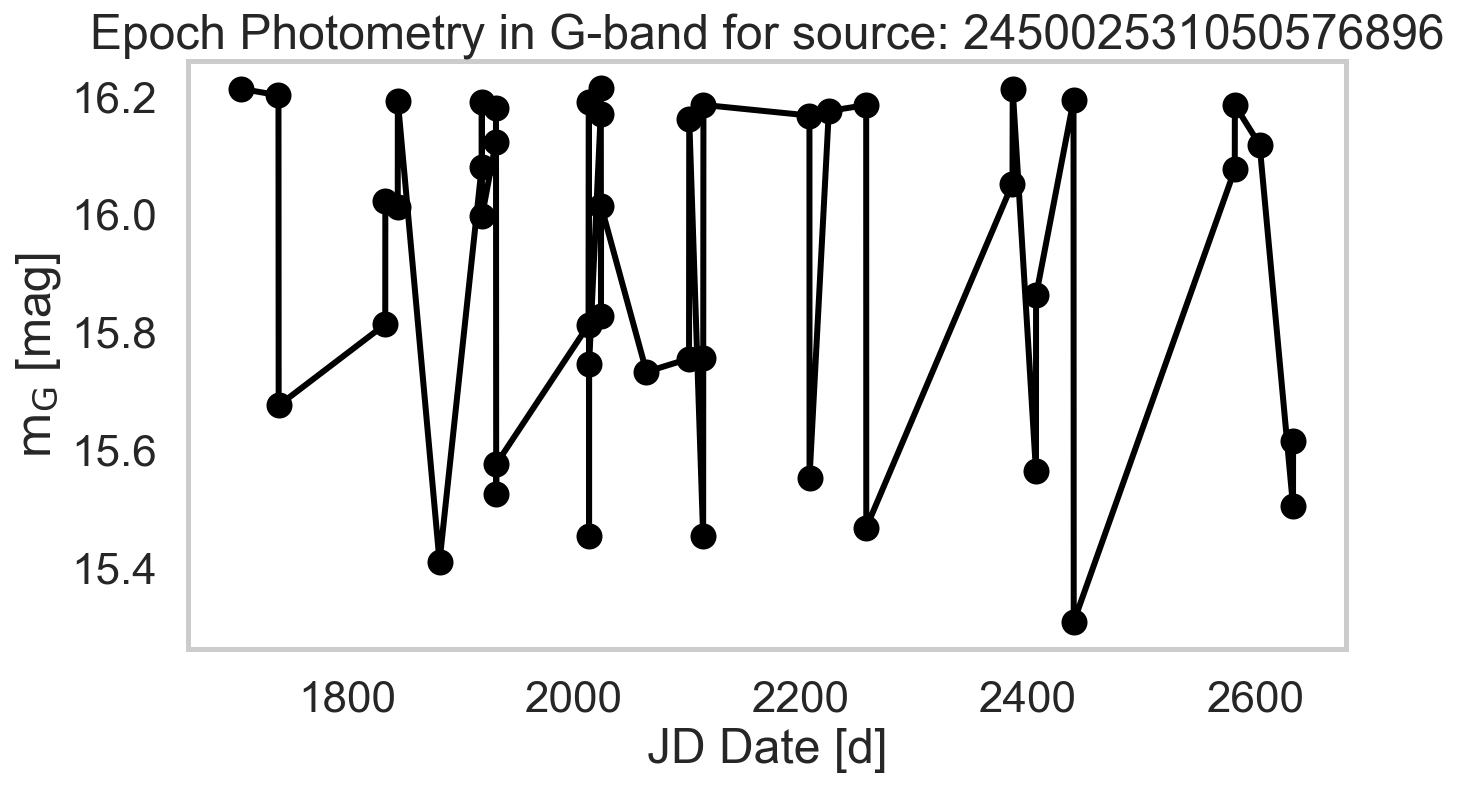

In [8]:
# filter table for one source
source_id_RRab0 = 245002531050576896 # first source
phot_set_RRab0 = tbl_dtlnk_RRab[
    (tbl_dtlnk_RRab['band'] == 'G') & 
    (tbl_dtlnk_RRab['source_id'] == source_id_RRab0)
]
phot_set_RRab0.sort('time')

# plotting a single light curve
plt.figure(figsize=(10,6))
plt.plot(
    phot_set_RRab0['time'],
    phot_set_RRab0['mag'],
    'o-',
    c='black'
)
plt.xlabel('JD Date [d]')
plt.ylabel(r'$\rm m_G$ [mag]')
plt.title(f'Epoch Photometry in G-band for source: {source_id_RRab0}')
plt.grid()
plt.tight_layout()
plt.show()

## 3. Period and Mean Magnitude Estimation

Estimate the period and mean G-band magnitude of the 100 downloaded light curves using a Lomb-Scargle periodogram (astropy.timeseries.LombScargle). Plot the periodogram for one light curve and with the estimated period.
<br>

$\textbf{Clementinin et al. 2016}$: RR Lyrae classified with period $0.2 \leq P \leq 1$ which translates to a frequency range $1 \leq f \leq 5$.
<br>

Below are some preliminary work for a single source to figure out what functions need to be constructed.

Frequency of largest power peak: 1.92 cycle/day
Estimated period: 0.52 day


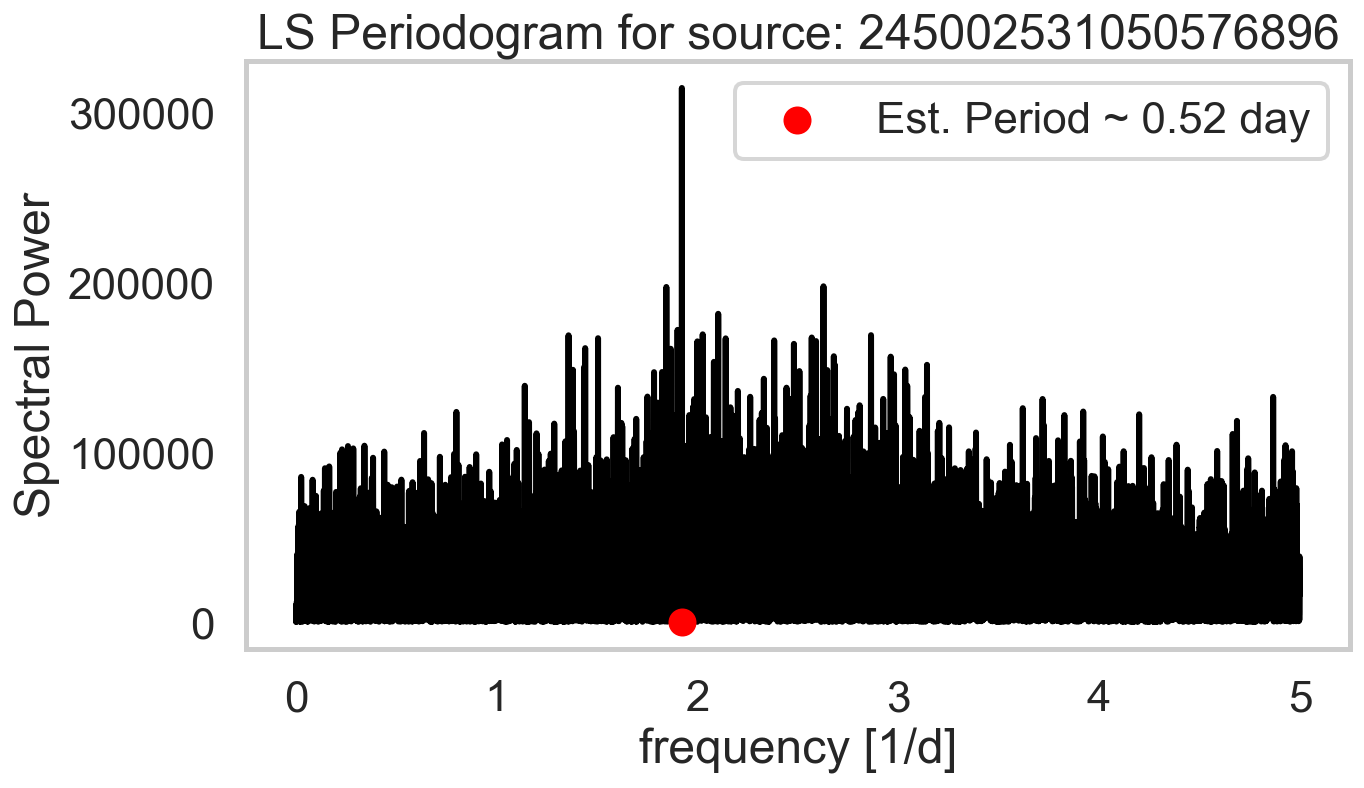

In [9]:
phot_set_RRab0.sort('source_id')

# labeled wrt source
time_RRab0 = np.array(phot_set_RRab0['time'])
mag_RRab0 = np.array(phot_set_RRab0['mag'])
mag_error_RRab0 = np.array(phot_set_RRab0['mag_error'])

# Get LS periodogram for source
freq_RRab0, pls_RRab0 = LombScargle(
    time_RRab0, mag_RRab0, mag_error_RRab0,
    fit_mean=False, 
    center_data=True
).autopower(
    minimum_frequency=0,
    maximum_frequency=5,
    normalization='psd', # unnormalized periodogram;
                         # comparable to Fourier power spectral density
    samples_per_peak=5
)

# index of largest power peak (non-NaN)
pls_max_idx_RRab0 = np.nanargmax(pls_RRab0)

# frequency value at max power
freq_pmax_val_RRab0 = freq_RRab0[pls_max_idx_RRab0]

# estimated period value at max power
# set to zero if divide by zero
if freq_pmax_val_RRab0 != 0:
    period_est_val_RRab0 = 1/freq_pmax_val_RRab0
else:
    period_est_val_RRab0 = 0

print(f'Frequency of largest power peak: {round(freq_pmax_val_RRab0, 2)} cycle/day')
print(f'Estimated period: {round(period_est_val_RRab0, 2)} day')

# plot LS periodogram
plt.figure(figsize=(10,6))
plt.plot(freq_RRab0, pls_RRab0, c='black', zorder=0)
plt.scatter(
    freq_pmax_val_RRab0, 0, 
    c='red', 
    label=f'Est. Period ~ {round(period_est_val_RRab0, 2)} day', 
    zorder=1
)
plt.xlabel('frequency [1/d]')
plt.ylabel('Spectral Power')
plt.title(f'LS Periodogram for source: {source_id_RRab0}')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [10]:
# period estimate for 100 RRab light curves
period_est_RRab = np.array(estimate_period(tbl_dtlnk_RRab))

# print(f'Period estimate for 100 RRab light curves: \n {period_est_RRab}')

# print()

# mean magnitude estimate for 100 RRab light curves
mean_mag_est_RRab = np.array(estimate_mean_magnitude(tbl_dtlnk_RRab))

# print(f'Mean magnitude estimate for 100 RRab light curves: \n {mean_mag_est_RRab}')

## 4. Comparison to GDR3

Compare the estimated periods to the values reported in the vari_rrlyrae catalog

In [11]:
# 100 unique source ids for datalink table
unique_srcids_RRab = get_unique_source_ids(tbl_dtlnk_RRab)

# construct comparison dataframe
est_data_RRab = {
    'source_id': unique_srcids_RRab,
    'pf_gdr3': tbl_RRab['pf'],
    'period_est': period_est_RRab,
    'mag_gdr3': tbl_RRab['int_average_g'],
    'mean_mag_est': mean_mag_est_RRab
}
df_est_data_RRab = pd.DataFrame(est_data_RRab)
df_est_data_RRab

,source_id,pf_gdr3,period_est,mag_gdr3,mean_mag_est
0,245002531050576896,0.520512,0.520487,15.929145,15.870378
1,245504251951140864,0.507115,0.507130,18.000160,17.969103
2,245823861938360064,0.478764,0.478795,19.339872,19.323328
3,246756973652292992,0.489303,0.489275,12.362016,12.312440
4,359112665277840512,0.501780,0.501785,15.893806,15.913452
...,...,...,...,...,...
95,6061741130185585280,0.459523,0.459509,18.010958,17.996277
96,6061807062215683072,0.642767,0.642805,19.626209,19.610502
97,6061866508861866240,0.397575,8.132802,19.897871,19.863476
98,6061867986376466688,0.766155,0.766113,16.289972,16.310418


Mean of residual in period: 0.22 +/- 0.14


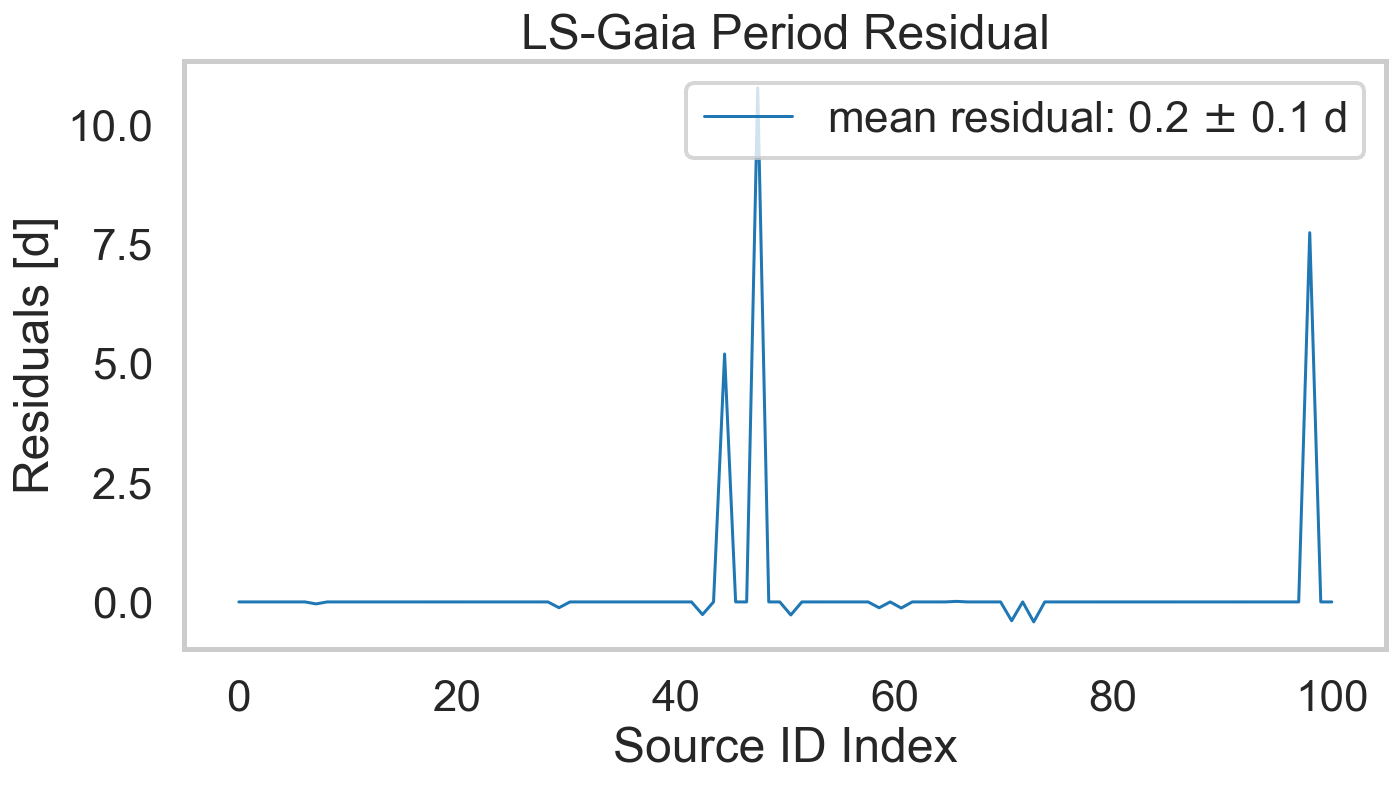

In [12]:
# period residuals
pf_RRab = np.array(tbl_RRab['pf'])
period_residual_RRab = period_est_RRab - pf_RRab

# period residual mean and error
prd_rsdl_mean_RRab = np.mean(period_residual_RRab)
prd_rsdl_err_RRab = np.std(period_residual_RRab)/np.sqrt(len(period_residual_RRab))
print(f'Mean of residual in period: {round(prd_rsdl_mean_RRab, 2)} +/- {round(prd_rsdl_err_RRab, 2)}')

# plot residuals
x = np.linspace(0, len(period_residual_RRab), len(period_residual_RRab))
plt.figure(figsize=(10,6))
plt.plot(
    x, period_residual_RRab,
    linewidth=1.5,
    label=r'mean residual: %.1f $\pm$ %.1f d'%(prd_rsdl_mean_RRab, prd_rsdl_err_RRab)
)
plt.title('LS-Gaia Period Residual')
plt.xlabel('Source ID Index')
plt.ylabel('Residuals [d]')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

$\textbf{Comment on the results}$
<br>

The period estimate matches up with the gaia value well, besides the residual spike for that one source (find it with np.argmax).

## 5. Fourier Series Representation

A periodic, smooth function $f$ can be represented by the Fourier series decomposition

\begin{equation}
f\left(t\right) = A_0 + \sum_{k=1}^{K} a_k \sin\left(k\omega t\right) + b_k \cos\left(k\omega t\right)
\end{equation}

where $A_0$, $a_k$, and $b_k$ are constants ($a_k$ and $b_k$ are arrays with $K$ terms), and $\omega = \frac{2\pi}{P}$ is the angular frequency. If $\omega$ is known, then the series representation can be written in matrix notation as $y = \textbf{X}\beta$. Here $y$ is an array of measured fluxes, $\textbf{X}$ is a matrix constructed from known quantities, and $\beta$ is an array of unknowns. $\textbf{X}$ is a $\left(2\text{K} + 1\right) \times \text{K}$ matrix, and $\beta$ is a $1 \times \left(2\text{K} + 1\right)$ column vector.

\begin{equation}
\textbf{X}\beta = \begin{pmatrix}
        1 & \sin\left(1\omega t\right) & \cos\left(1\omega t\right) & \cdots & \sin\left(k\omega t\right) & \cos\left(k\omega t\right) \\
        \vdots & & & & & \vdots \\
        1 & \sin\left(1\omega t\right) & \cos\left(1\omega t\right) & \cdots & \sin\left(k\omega t\right) & \cos\left(k\omega t\right)
    \end{pmatrix}\begin{pmatrix}
        A_0 \\ a_1 \\ b_1 \\ \vdots \\ a_k \\ b_k
    \end{pmatrix}
\end{equation}

## 6. Fourier Decomposition of an RR Lyrae

For the star with Gaia DR3 id = $5817567360327589632$, determine the series representations for $K$ = 1, 3, 5, 7, and 9. Plot the phased light curve, the series representation on a fine grid, and the residuals between the data and series representations for each $K$.
<br>

Since the star is no longer contained in the original gaia query, we'd have to repeat some steps to acquire raw light curves from datalink.

/var/folders/79/pc1qvlln7jv_xsqbggrvys9m0000gn/T/ipykernel_54157/3666871803.py:362: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))
/var/folders/79/pc1qvlln7jv_xsqbggrvys9m0000gn/T/ipykernel_54157/3666871803.py:362: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))
/var/folders/79/pc1qvlln7jv_xsqbggrvys9m0000gn/T/ipykernel_54157/3666871803.py:362: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays

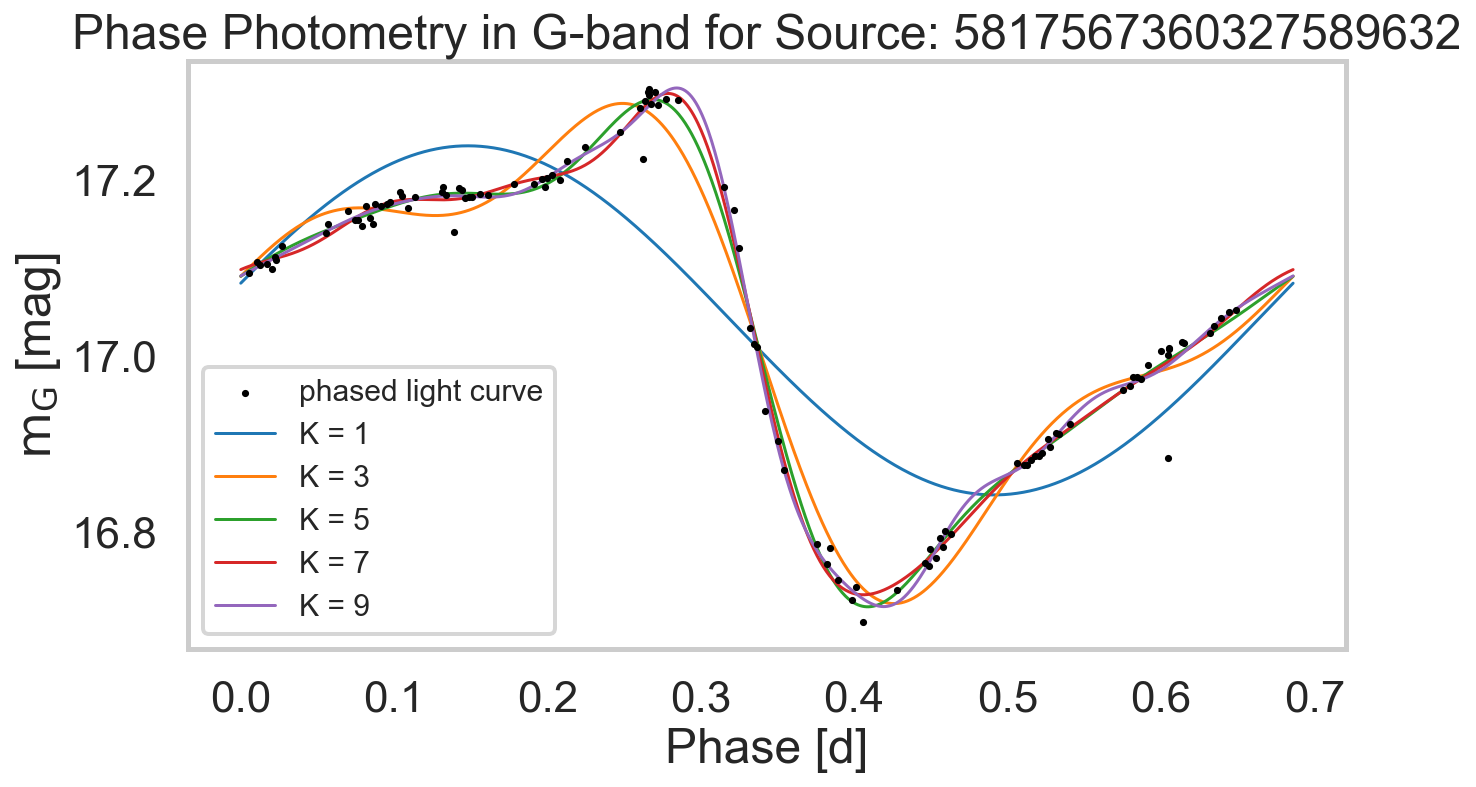

/var/folders/79/pc1qvlln7jv_xsqbggrvys9m0000gn/T/ipykernel_54157/3666871803.py:362: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))


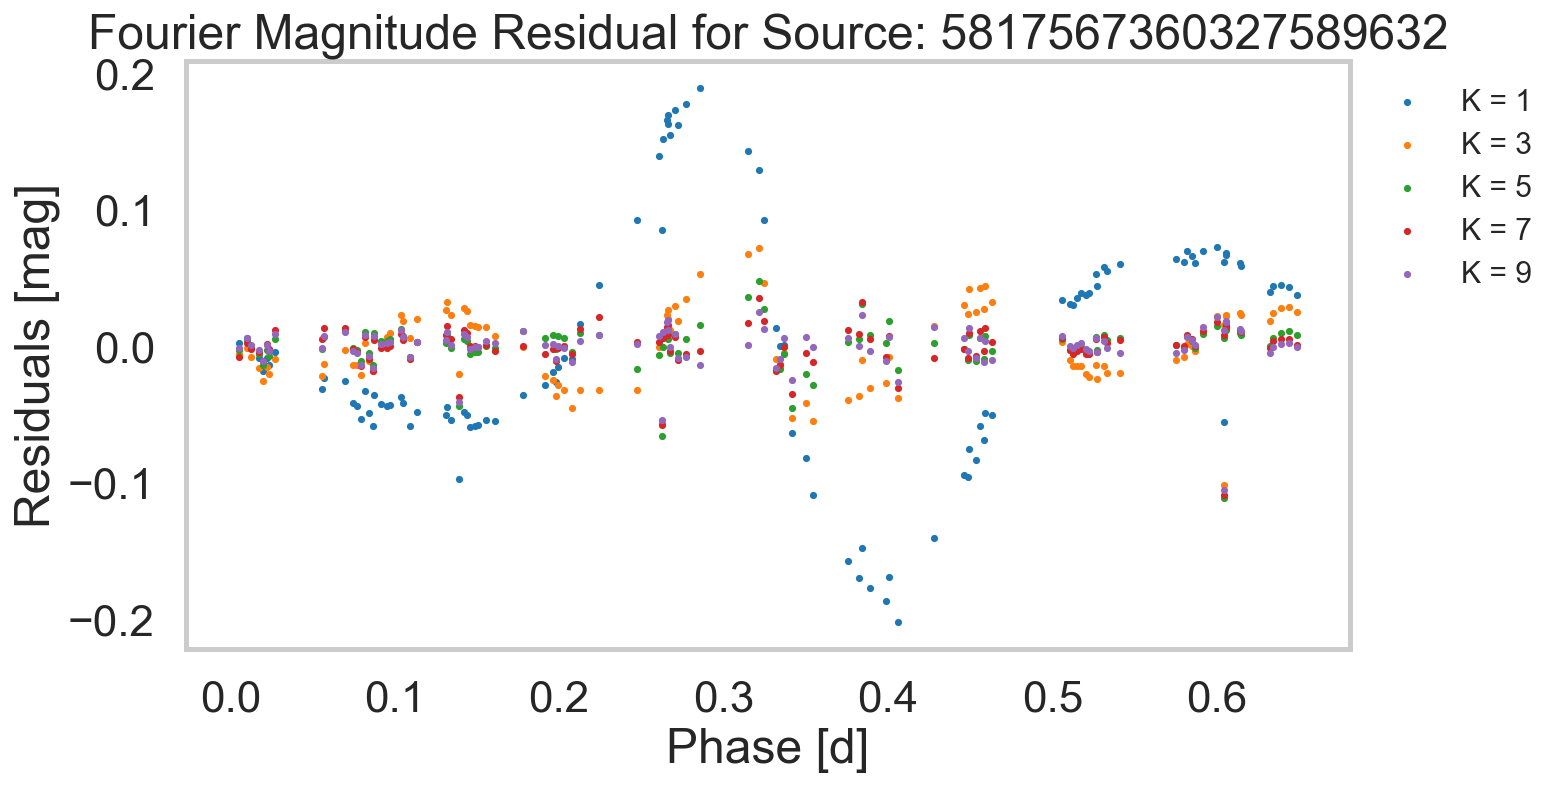

In [13]:
# Repeat datalink download for source of interest
# Source used to be 7th in the datalink
# So I numbered it as such
source_id_RRab7 = 5817567360327589632

# datalink metadata
data_release = 'Gaia DR3'
retrieval_type = 'EPOCH_PHOTOMETRY'
data_structure = 'COMBINED'

# get datalink
datalink_RRab7 = Gaia.load_data(
        ids = source_id_RRab7,
        data_release = data_release,
        retrieval_type = retrieval_type,
        data_structure = data_structure,
        verbose = False,
        output_file = None
    )
    
dl_keys_RRab7 = [inp for inp in datalink_RRab7.keys()]
dl_keys_RRab7.sort()
dl_key_RRab7 = dl_keys_RRab7[0]

# convert to astropy table
tbl_dtlnk_RRab7 = datalink_RRab7[dl_key_RRab7][0].to_table()
tbl_dtlnk_sorted_RRab7 = tbl_dtlnk_RRab7.copy()
tbl_dtlnk_sorted_RRab7.sort('source_id')
tbl_RRab7 = add_mag_error_column(tbl_dtlnk_sorted_RRab7)

# plot fourier decomposition
time_RRab7, mag_RRab7 = get_time_mag(tbl_RRab7)

plt.figure(figsize=(10,6))
plot_phase_phot(tbl_RRab7)

K = [1, 3, 5, 7, 9]

for k in K:
    plot_fourier_decomp(tbl_RRab7, k)
plt.legend(frameon=True, prop={'size':15})
# plt.savefig('240213_lab1-1-6a.png', format='png', dpi=200)
plt.show()

# residuals
plt.figure(figsize=(10,6))
plot_fourier_residual(tbl_RRab7, K)
plt.legend(frameon=False, prop={'size':15}, bbox_to_anchor=(1.0, 1.0))
# plt.savefig('240213_lab1-1-6b.png', format='png', dpi=200)
plt.show()

## 7. Optimal $K$ with Cross-Validation

Use cross-validation to find an optimal $K$. Designate 20% of the observed points as the cross-validation set. For $K$ ranging from 1 to 25, calculate $\chi^2/N_{\text{data}}$ for both the training data (which enters y) and the cross-validation data (which does not). Plot $\chi^2/N_{\text{data}}$ as a function of $K$. $\textbf{Discuss what an appropriate value of $K$ for this data set might be}$.

/var/folders/79/pc1qvlln7jv_xsqbggrvys9m0000gn/T/ipykernel_54157/3666871803.py:362: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))


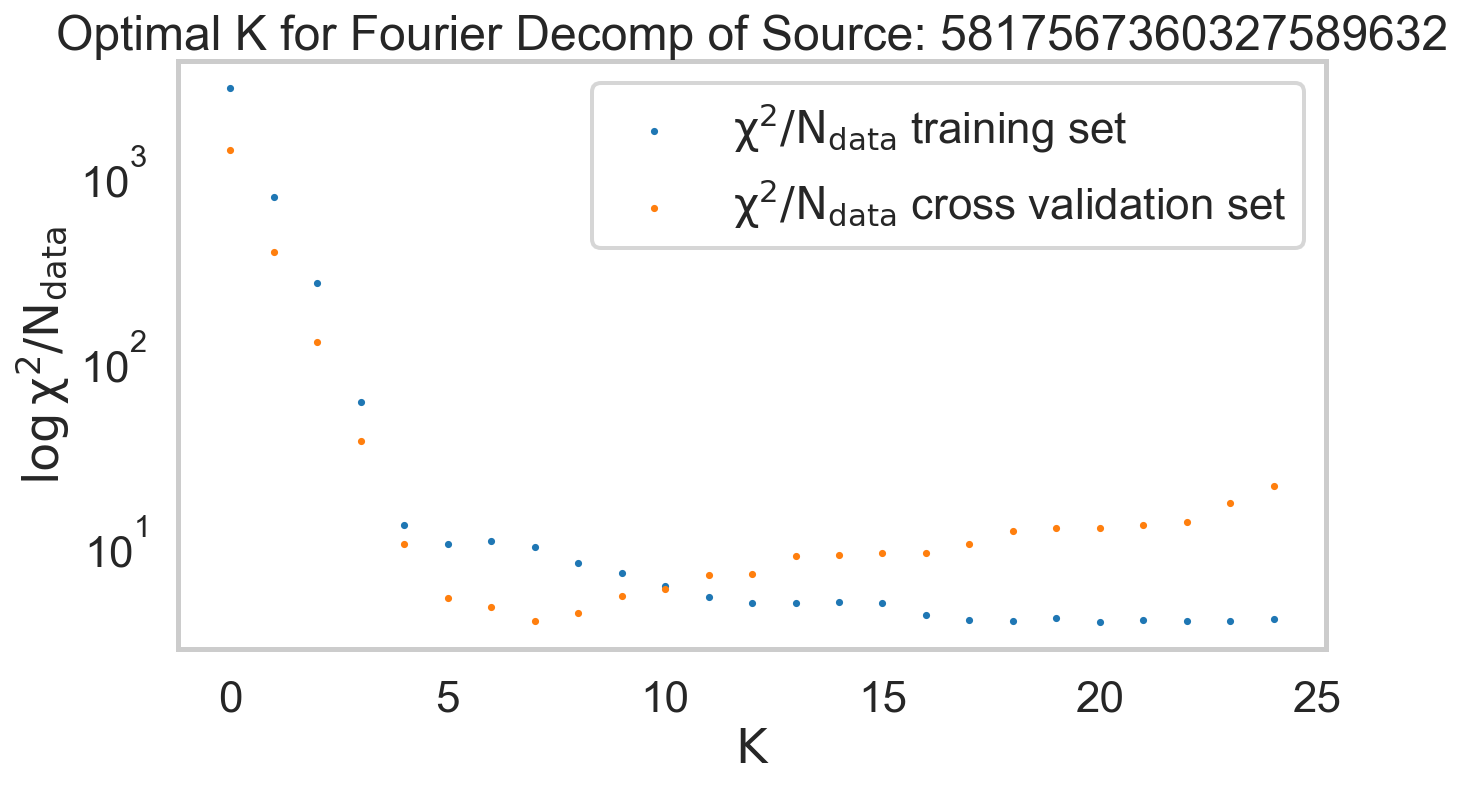

In [14]:
# period
period_est_RRab7 = estimate_period(tbl_RRab7)

# magnitude uncertainty
mag_error_RRab7 = get_mag_error(tbl_RRab7)

# stack magnitude and magnitude uncertainty
magnerror_RRab7 = np.stack((mag_RRab7, mag_error_RRab7), axis = -1)

# set 20% of observed data as cross-validation set
# so 80% to use for training
time_train, time_test, magnerror_train, magnerror_test = train_test_split(
    time_RRab7,
    magnerror_RRab7, 
    train_size = 0.8,
    random_state = 42 # random sort
)

# K ranging from 1 to 25
K = [x for x in range(25)]

# chi2 for training set
chi2s_train = []
# chi2 for cross-validation set
chi2s_test = []

for k in K:
    # training matrix
    X_train = X_matrix(time_train, k, period_est_RRab7)
    # model
    coef, residuals, rank, s = least_squares(X_train, magnerror_train[:, 0])
    # prediction from model
    m_train = reconstruct_mag(coef, time_train, k, period_est_RRab7)
    # chi2 between prediction and observed training data
    chi2_train = np.sum((magnerror_train[:, 0] - m_train)**2/magnerror_train[:, 1]**2) / len(time_train)
    chi2s_train.append(chi2_train)
    
    # testing matrix
    X_test = X_matrix(time_test, k, period_est_RRab7)
    # prediction using model from training set
    m_test = reconstruct_mag(coef, time_test, k, period_est_RRab7)
    # chi2 between prediction with model from training set
    # and observed testing data
    chi2_test = np.sum((magnerror_test[:, 0] - m_test)**2/magnerror_test[:, 1]**2) / len(time_test)
    chi2s_test.append(chi2_test)

plt.figure(figsize=(10,6))
plt.scatter(K, chi2s_train, marker='.', label=r'$\rm \chi^2 / N_{data}$ training set', s=10)
plt.scatter(K, chi2s_test, marker='.', label=r'$\rm \chi^2 / N_{data}$ cross validation set', s=10)
plt.title(f'Optimal K for Fourier Decomp of Source: {source_id_RRab7}')
plt.xlabel(r'$\rm K$')
plt.ylabel(r'$\rm \log \chi^2 / N_{data}$')
plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## 8. Magnitude Extrapolation

Using a value of $K$ chosen based on the previous problem, predict the expected magnitude of the star exactly 10 days after the last observed data point. Plot the light curve, showing the last few days of Gaia data points, the extrapolation over the next 12 days, and indicating your best estimate for the magnitude exactly 10 days after the last data point.

In [15]:
tbl_RRab7

source_id,transit_id,band,time,mag,mag_error,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id
,,,d,mag,mag,electron / s,electron / s,,,,,
int64,int64,object,float64,float64,float32,float64,float64,float32,bool,bool,int64,int64
5817567360327589632,17082357705273918,G,1705.7703894831616,16.882781187373517,0.14735523,3325.326335902114,451.310574217743,7.368155,False,True,4105,375316653866487564
5817567360327589632,71758337382310206,BP,2694.5611701630714,17.33691946976736,0.016387895,1587.2637517679066,23.95785557349508,66.25233,False,False,0,375316653866487564
5817567360327589632,71748596473849295,BP,2694.3850055608705,17.002780705207005,0.012882308,2159.258332681098,25.619694872525013,84.28119,False,False,0,375316653866487564
5817567360327589632,71744504167548549,BP,2694.3109962093645,17.11723790721546,0.01839721,1943.2188893083924,32.92679088471862,59.016346,False,False,0,375316653866487564
5817567360327589632,71734763379143386,BP,2694.1348337592076,17.590154702918017,0.0188548,1257.0570994769014,21.829943908982123,57.584072,False,False,0,375316653866487564
5817567360327589632,71730671126975331,BP,2694.060825338526,17.525782413168464,0.019234639,1333.8405647725629,23.629995991075244,56.446922,False,False,0,375316653866487564
...,...,...,...,...,...,...,...,...,...,...,...,...
5817567360327589632,70974049192944443,G,2680.376860272204,17.187933374548155,0.0036792734,2510.5761396538314,8.507679552405277,295.09528,False,False,1,375316653866487564


Last data point: 16.87686295357738 mag at 2680.0526742695165 days.


/var/folders/79/pc1qvlln7jv_xsqbggrvys9m0000gn/T/ipykernel_15195/3666871803.py:362: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.matmul(X, np.transpose(coef))


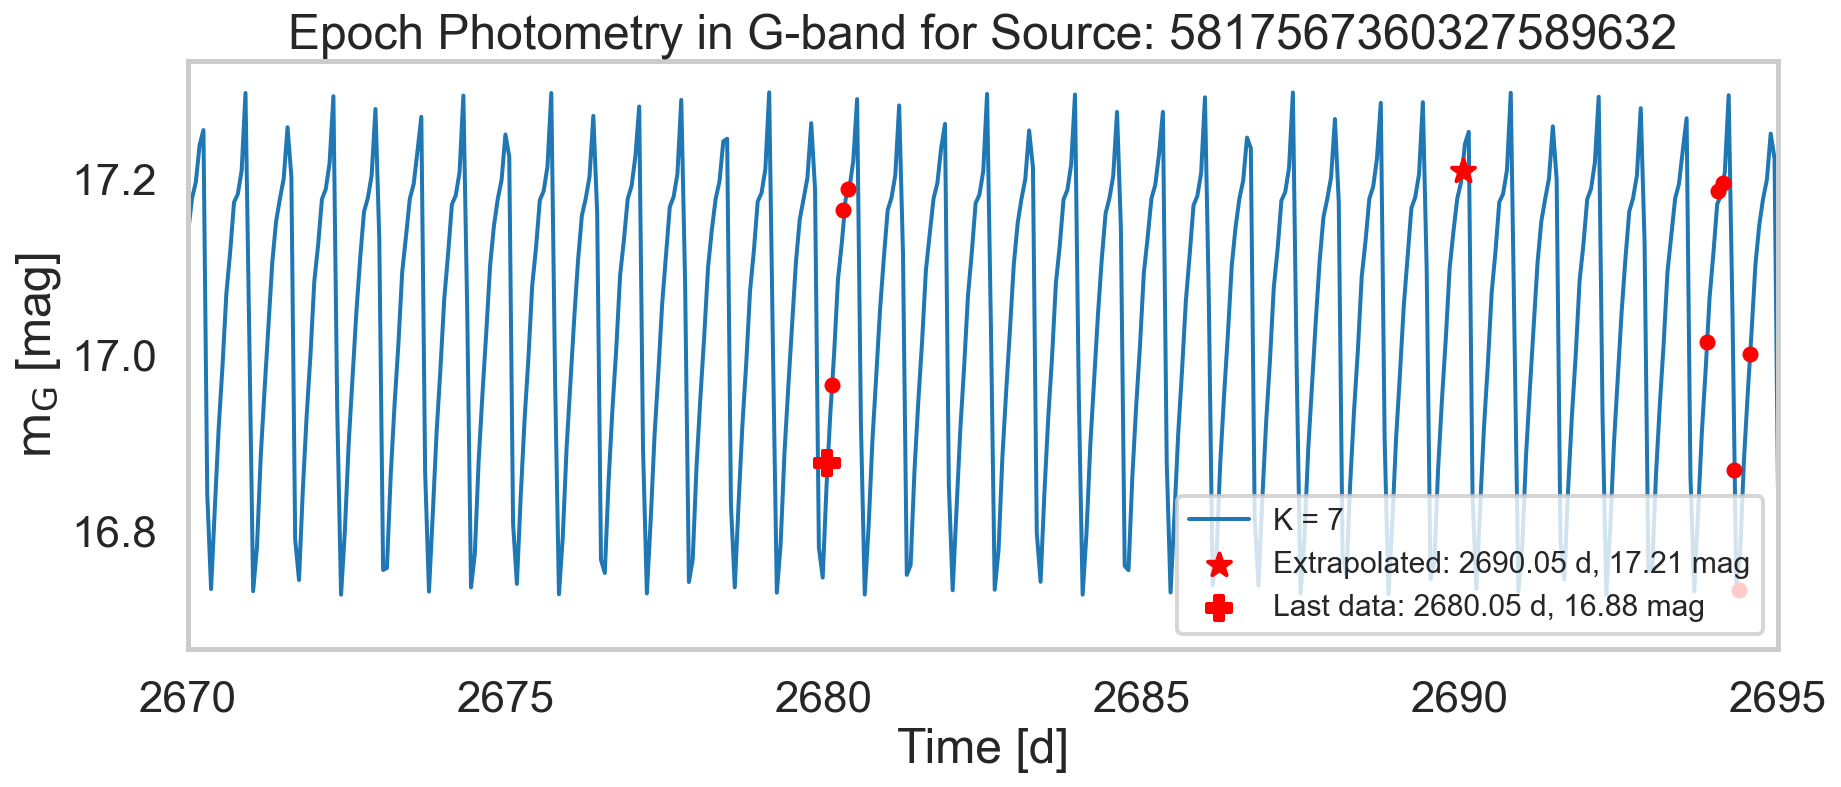

In [19]:
plt.figure(figsize=(13,6))
# epoch photometry
plot_epoch_phot(tbl_RRab7)

# find last data point
last_time_RRab7, last_mag_RRab7 = time_RRab7[-1], mag_RRab7[-1]
print(f'Last data point: {last_mag_RRab7} mag at {last_time_RRab7} days.')

# Fourier decomposition
K = 7
X = X_matrix(time_RRab7, K, period_est_RRab7)
coef, residuals, rank, s = least_squares(X, mag_RRab7)

# Fourier curve
t_RRab7 = np.linspace(2670, 2700, 500)
m_RRab7 = reconstruct_mag(coef, t_RRab7, K, period_est_RRab7)
plt.plot(
    t_RRab7, m_RRab7, 
    label=f'K = {K}', 
    linewidth=2, 
    zorder=0
)

# extrapolation of magnitude to 10 days
# after last measured data point
m_extrap_RRab7 = reconstruct_mag(
    coef, last_time_RRab7+10, 
    K, period_est_RRab7
)

# plot extrapolation
plt.scatter(
    last_time_RRab7+10, 
    m_extrap_RRab7, 
    marker='*', 
    c='red', 
    label=f'Extrapolated: {round(last_time_RRab7+10,2)} d, {round(m_extrap_RRab7,2)} mag'
)
plt.scatter(
    last_time_RRab7, 
    last_mag_RRab7, 
    marker='P', 
    c='red', 
    label=f'Last data: {round(last_time_RRab7,2)} d, {round(last_mag_RRab7,2)} mag'
)
plt.xlim(2670,2695)
plt.legend(prop={'size':15}, loc='lower right')
# plt.savefig('240213_lab1-1-8.png', format='png', dpi=200)
plt.show()

## 9. Fourier Representation Mean Magnitude Estimation

Calculate the mean magnitude based on the mean flux when averaging over one pulsation period, ie estimate the mean magnitude using the Fourier model for each of the 100 light curves.

In [ ]:
# number of fourier terms
K = 7

# fourier magnitudes
mag_fourier_RRab = np.array(fourier_decomp(tbl_dtlnk_RRab, K))
mean_mag_fourier_RRab = np.array(get_fourier_mean_mag(mag_fourier_RRab))

# construct dataframe
# collect data from
# gdr3, datalink, and
# fourier decomposition
data_compare_RRab = {
    'source_id': unique_srcids_RRab,
    'pf_gdr3': tbl_RRab['pf'], # gdr3 fundamental pulsation mode
    'period_ls': period_est_RRab * u.day, # Lomb-Scargle estimated period
    'mean_mag_gdr3': tbl_RRab['int_average_g'], # gdr3 intensity-averaged g-mag
    'mean_mag_dtlnk': mean_mag_est_RRab * u.mag, # datalink estimated mean mag
    'mean_mag_fdcmp': mean_mag_fourier_RRab * u.mag # fourier decomposition
}

df_compare_RRab = pd.DataFrame(data_compare_RRab)
# df_compare_RRab

In [ ]:
# source id index
x_RRab = np.linspace(1, 100, 100)

# plot to compare magnitudes
plt.figure(figsize=(13, 6))

# define dataset to reduce plotting code
plot_dataset_RRab = {
    'GDR3': df_compare_RRab['mean_mag_gdr3'],
    'Datalink Estimate': df_compare_RRab['mean_mag_dtlnk'],
    'Fourier Decomposition Estimate': df_compare_RRab['mean_mag_fdcmp']
}

# plot each dataset
for label, data in plot_dataset_RRab.items():
    plt.plot(x_RRab, data, linewidth=2.0, label=label)

plt.title('Mean Magnitude for 100 Sources')
plt.xlabel('Gaia Source ID Index')
plt.ylabel(r'$\rm m_G$ [mag]')
plt.grid()
plt.legend(frameon=False, prop={'size':15}, bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

# calculate residuals
residual_dtlnk_RRab = df_compare_RRab['mean_mag_gdr3'] - df_compare_RRab['mean_mag_dtlnk']
residual_fdcmp_RRab = df_compare_RRab['mean_mag_gdr3'] - df_compare_RRab['mean_mag_fdcmp']

# plot residuals
plt.figure(figsize=(13, 6))
plt.plot(
    x_RRab,
    residual_dtlnk_RRab,
    linewidth=2.0,
    linestyle=':',
    label='Residual Datalink-GDR3'
)
plt.plot(
    x_RRab,
    residual_fdcmp_RRab, 
    linewidth=2.0, 
    linestyle='--', 
    label='Residual Fourier-GDR3'
)
plt.title('Mean Magnitude Residuals for 100 Sources')
plt.xlabel('Gaia Source ID Index')
plt.ylabel(r'$\rm \Delta m_G$ [mag]')
plt.grid()
plt.legend(frameon=False, prop={'size':15}, bbox_to_anchor=(1.0, 1.0))
plt.tight_layout()
plt.show()

$\textbf{Comment on results}$

## 10. Class RRab and RRc Comparison

Download light curves for the top 3 RR Lyrae in the vari_rrlyrae catalog that have best_classification = "RRc", mean G-band magnitudes brighter than 15, and more than 80 clean epochs in the G-band. Using a suitable number of terms, compute Fourier expansions for these three light curves. Plot the phased light curves and overplot their Fourier models.
<br>

### Top 3 RRc Light Curves

In [ ]:
# query for top 3 RRc class RR Lyrae
query_RRc = """
    SELECT TOP 3 *
    FROM gaiadr3.vari_rrlyrae
    WHERE best_classification = 'RRc'
    AND int_average_g > 15
    AND num_clean_epochs_g > 80
"""

# get gaia query
tbl_RRc = get_gaia_query(query_RRc)
tbl_RRc.sort('source_id')

# get raw light curves for RRc
tbl_dtlnk_RRc = get_datalink(tbl_RRc, data_release, retrieval_type, data_structure)
# tbl_dtlnk_RRc

In [ ]:
K_list = [x for x in range(25)]
# determine optimal K for RRc
plot_cross_validate(tbl_dtlnk_RRc, K_list)

In [ ]:
# plot phase photometry and fourier decomposition
# for RRc class RR Lyrae
optimal_K_RRc = [3, 3, 8]
unique_sources_RRc = np.unique(tbl_dtlnk_RRc['source_id'])
for i, source in enumerate(unique_sources_RRc):
    tbl_dtlnk_sngl_src_RRc = tbl_dtlnk_RRc[tbl_dtlnk_RRc['source_id'] == source]
    plt.figure(figsize=(13,6))
    plot_phase_phot(tbl_dtlnk_sngl_src_RRc)
    plot_fourier_decomp(tbl_dtlnk_sngl_src_RRc, optimal_K_RRc[i])
    plt.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')
    plt.show()

### Top 3 RRab Light Curves

In [ ]:
# query for top 3 RRab class RR Lyrae
query_top3_RRab = """
    SELECT TOP 3 *
    FROM gaiadr3.vari_rrlyrae
    WHERE best_classification = 'RRab'
    AND int_average_g > 15
    AND num_clean_epochs_g > 80
"""

# get gaia query
tbl_top3_RRab = get_gaia_query(query_top3_RRab)
tbl_top3_RRab.sort('source_id')

# get raw light curves for RRc
tbl_dtlnk_top3_RRab = get_datalink(tbl_top3_RRab, data_release, retrieval_type, data_structure)
# tbl_dtlnk_top3_RRab

In [ ]:
# find optimal K
plot_cross_validate(tbl_dtlnk_top3_RRab, K_list)

In [ ]:
K_optimal_top3_RRab = [5, 14, 17]
# plot phase photometry and fourier decomposition
# for RRab class RR Lyrae
unique_sources_top3_RRab = np.unique(tbl_dtlnk_top3_RRab['source_id'])

for i, source in enumerate(unique_sources_top3_RRab):
    tbl_dtlnk_sngl_src_top3_RRab = tbl_dtlnk_top3_RRab[tbl_dtlnk_top3_RRab['source_id'] == source]
    plt.figure(figsize=(13,6))
    plot_phase_phot(tbl_dtlnk_sngl_src_top3_RRab)
    plot_fourier_decomp(tbl_dtlnk_sngl_src_top3_RRab, K_optimal_top3_RRab[i])
    plt.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')
    plt.show()
    
for source in unique_sources_top3_RRab:
    tbl_dtlnk_sngl_src_top3_RRab = tbl_dtlnk_top3_RRab[tbl_dtlnk_top3_RRab['source_id'] == source]
    plt.figure(figsize=(13,6))
    plot_phase_phot(tbl_dtlnk_sngl_src_top3_RRab)
    plot_fourier_decomp(tbl_dtlnk_sngl_src_top3_RRab, 7)
    plt.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')
    plt.show()

Comment on the difference in light curve shape between the two classes. Do some reading about the difference between the RRab and RRc classes.

## 11. Deviations from Simple Periodicity in RR Lyrae

Are the 6 light curves well-described by a single period, or is there evidence of intrinsic scatter? Read about deviations from simple periodicity in RR Lyrae in $\textbf{Netzel et al. 2018}$ and discuss.

## 12. Query for RR Lyraes Outside Galactic Disk

Write an ADQL query to select RR Lyrae stars that have: accurately measured distances, with parallax errors of less than 20%; are above or below the disk, with $\left|b\right| > 30$ degrees, where $b$ is Galatic latitude; are relatively nearby, with distances less than 4 kpc. To do this, join the gaiadr3.vari_rrlyrae and gaiadr3.gaia_source catalogs. There should be about 500 sources.

$$d < \frac{1}{\varpi} \to \varpi > \frac{1}{d} = \frac{10^3}{4\cdot10^3}\,\text{mas} = 0.25\,\text{mas}$$

In [ ]:
# query for off-disk RR Lyraes
query_off_disk = """
    SELECT TOP 500
    
    source_id,
    parallax,
    parallax_over_error,
    b,
    
    pf,
    pf_error,
    int_average_g,
    int_average_g_error
    
    FROM gaiadr3.vari_rrlyrae 
    JOIN gaiadr3.gaia_source USING (source_id)
    
    WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g IS NOT NULL
    AND parallax_over_error >= 10
    AND ABS(b) >= 30
    AND parallax >= 0.25
    AND pf IS NOT NULL
"""

tbl_off_disk = get_gaia_query(query_off_disk)
# tbl_off_disk

Explain why using Gaia distances to estimate the absolute magnitude of RR Lyraes will only work if there is not a lot of dust between us and the RR Lyraes.

## 13. GEDR3 Distance Estimates

$\textbf{Bailer-Jones et al. 2020}$
<br>

Write an ADQL query to get from external.gaiaedr3_distance the geometric distance estimates (r_med_geo, r_hi_geo, and r_lo_geo) and their uncertainties for the sources obtained in part 12. Also add galactic longitude for part 14.

In [ ]:
# query for off-disk RR Lyraes
# with Bailer-Jones geometric distances
query_off_disk_bj = """
    SELECT TOP 500
    
    source_id,
    parallax,
    parallax_error,
    parallax_over_error,
    b,
    l,
    
    pf,
    pf_error,
    int_average_g,
    int_average_g_error,
    
    r_med_geo,
    r_lo_geo,
    r_hi_geo
    
    FROM gaiadr3.vari_rrlyrae 
    JOIN gaiadr3.gaia_source USING (source_id)
    JOIN external.gaiaedr3_distance USING (source_id)
    
    WHERE gaiadr3.vari_rrlyrae.num_clean_epochs_g IS NOT NULL
    AND parallax_over_error >= 10
    AND ABS(b) >= 30
    AND parallax >= 0.25
    AND pf IS NOT NULL
"""

tbl_off_disk_bj = get_gaia_query(query_off_disk_bj)
# tbl_off_disk_bj

Explain how these geometric distances are calculated. What is the important difference between these distance and what you'd get by just inverting the parallaxes?

## 14. EDR3 vs. Bailer-Jones Parallaxes

Plot the distribution of sources obtained in Galactic coordinates. Verify that the ADQL query has removed stars in the Galactic disk.

In [ ]:
# get galactic coordinates
galactic_longitude = np.array(tbl_off_disk_bj['l'])
galactic_latitude = np.array(tbl_off_disk_bj['b'])

plt.figure(figsize=(10,6))
plt.scatter(galactic_longitude, galactic_latitude, marker='.', s=10, c='black')
plt.title('RR Lyrae Off-Disk')
plt.xlabel('Galactic Longitude [deg]')
plt.ylabel('Galactic Latitude [deg]')
plt.grid()
plt.tight_layout()
plt.show()

The galactic disk is devoid of sources, so the ADQL query did indeed only selected for off-disk stars.

In [ ]:
# source id index for plotting
x = np.linspace(0, len(tbl_off_disk_bj), len(tbl_off_disk_bj))

# parallax
prllx_gdr3 = np.array(tbl_off_disk_bj['parallax'])
prllx_err_gdr3 = np.array(tbl_off_disk_bj['parallax_error'])
prllx_over_err_gdr3 = np.array(tbl_off_disk_bj['parallax_over_error'])

# estimate distance
d_est_gdr3 = parallax2distance(prllx_gdr3)
d_est_err_gdr3 = 1/prllx_over_err_gdr3 * d_est_gdr3

# Bailer-Jones distances
d_bj = np.array(tbl_off_disk_bj['r_med_geo'])
# symmetrized error
d_err_bj = np.array((tbl_off_disk_bj['r_hi_geo']-tbl_off_disk_bj['r_lo_geo'])/2)

# Bailer-Jones parallax
prllx_bj = distance2parallax(d_bj)
# error propagation for parallax error
prllx_err_bj = d_err_bj/(d_bj**2) * 10**3

# construct dataframe for visual comparison
dataset_d_prllx = {
    'parallax_gdr3': prllx_gdr3,
    'parallax_error_gdr3': prllx_err_gdr3,
    'parallax_bj': prllx_bj,
    'parallax_error_bj': prllx_err_bj,
    'distance_gdr3': d_est_gdr3,
    'distance_error_gdr3': d_est_err_gdr3,
    'distance_bj': d_bj,
    'distance_error_bj': d_err_bj
}
df_d_prllx=pd.DataFrame(dataset_d_prllx)
df_d_prllx

In [ ]:
def plot_comparison(x, y, x_err, y_err, xlabel, ylabel, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, marker='.', s=10, c='black')
    plt.errorbar(
        x, y, 
        fmt='none', 
        xerr=x_err, 
        yerr=y_err, 
        elinewidth=0.5, 
        ecolor='red',
        alpha=0.5,
        zorder=0
    )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_residual(x, residual, xlabel, ylabel, title):
    plt.figure(figsize=(10,6))
    plt.plot(x, residual, linewidth=1.5, c='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.tight_layout()
    plt.show()

In [ ]:
# Distance comparison plot
plot_comparison(
    d_est_gdr3, 
    d_bj,
    d_est_err_gdr3, 
    d_err_bj,
    xlabel='GDR3 [pc]', 
    ylabel='Bailer-Jones [pc]', 
    title='Bailer-Jones vs GDR3 Distance Estimates'
)

# Calculate distance residual
d_rsdl = d_est_gdr3 - d_bj

# Plot distance residual
plot_residual(
    x, d_rsdl, 
    xlabel='Source ID Index', 
    ylabel=r'$\rm \Delta d$ [pc]', 
    title='GDR3-Bailey-Jones Distance Residual'
)

# Parallax comparison plot
plot_comparison(
    prllx_bj, 
    prllx_gdr3, 
    prllx_err_bj,
    prllx_err_gdr3,
    xlabel=r'Bailer-Jones $\varpi$ [mas]', 
    ylabel=r'GDR3 $\varpi$ [mas]', 
    title='GDR3 vs Bailer-Jones Parallax Estimates'
)

# Calculate parallax residual
prllx_rsdl = prllx_gdr3 - prllx_bj

# Plot parallax residual
plot_residual(
    x, prllx_rsdl, 
    xlabel='Source ID Index', 
    ylabel=r'$\rm \Delta \varpi$ [mas]', 
    title='GDR3-Bailey-Jones Parallax Residuals'
)

Compare the distance estimate from the Bailer-Jones catalog to the naive distance estimate from $d = 1/\varpi$. 
<br>
$\textbf{Explain the trend you see.}$ 
<br>
Compare the parallaxes, showing uncertainties as error bars.
<br>
$\textbf{How different are the DR3 parallaxes on average?}$ 
<br>
$\textbf{Are the DR3 and Bailer-Jones parallaxes generally consistent within their respective uncertainties?}$
<br>
$\textbf{Why or why not?}$

## 15. Period vs. Absolute G-band Magnitude

In [ ]:
# period from outside-disk query
periodf = np.array(tbl_off_disk_bj['pf'])
periodf_err = np.array(tbl_off_disk_bj['pf_error'])

# average gband magnitude
mg_avg = np.array(tbl_off_disk_bj['int_average_g'])
mg_avg_err = np.array(tbl_off_disk_bj['int_average_g_error'])

# absolute gband magnitude with Bailer-Jones distances
Mg_bj = get_absolute_mag(d_bj, mg_avg)

# absolute gband magnitude error
# with error propagation
Mg_err_bj = np.sqrt(mg_avg_err**2 + (5*d_err_bj/(d_bj*np.log(10)))**2)

# plot absolute gband magnitude
plt.figure(figsize=(10,6))
plt.scatter(
    periodf, Mg_bj,
    marker='.',
    s=10,
    c='black',
)
plt.errorbar(
    periodf, Mg_bj,
    xerr = periodf_err,
    fmt='none',
    capsize=7,
    elinewidth=0.5,
    ecolor='blue',
    alpha=0.5,
    zorder=0,
    label=r'$\rm \sigma_P$'
)
plt.errorbar(
    periodf, Mg_bj,
    yerr = Mg_err_bj,
    fmt='none',
    capsize=7,
    elinewidth=0.5,
    ecolor='red',
    alpha=0.5,
    zorder=0,
    label=r'$\rm \sigma_{M_G}$'
)
plt.title('Absolute G-band Magnitude Estimate')
plt.xlabel('Period [d]')
plt.ylabel(r'$\rm M_G$ [mag]')
plt.gca().invert_yaxis()
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 16. Lindegren Quality Cuts

Apply quality cuts (equations C1 and C2 of $\textbf{Lindegren et al. 2018}$) to query to reduce incorrectly measured parallaxes and remove absolute magnitude outliers.

In [ ]:
# query for off-disk RR Lyraes
# with quality cuts from Lindegren
query_off_disk_ql_cts = """
    SELECT TOP 500
    
    source_id,
    parallax,
    parallax_error,
    parallax_over_error,
    b,
    l,
    
    pf,
    pf_error,
    int_average_g,
    int_average_g_error,
    
    r_med_geo,
    r_lo_geo,
    r_hi_geo
    
    FROM gaiadr3.vari_rrlyrae 
    JOIN gaiadr3.gaia_source USING (source_id)
    JOIN external.gaiaedr3_distance USING (source_id)
    
    WHERE num_clean_epochs_g IS NOT NULL
    AND parallax_over_error >= 10
    AND ABS(b) >= 30
    AND parallax >= 0.25
    AND pf IS NOT NULL
    
    AND phot_bp_mean_flux_over_error > 10
    AND phot_rp_mean_flux_over_error > 10
    AND astrometric_excess_noise < 1
    AND phot_bp_rp_excess_factor < 1.3 + 0.06*POWER(BP_RP,2)
    AND phot_bp_rp_excess_factor > 1.0 + 0.015*POWER(BP_RP,2)
"""

tbl_off_disk_ql_cts = get_gaia_query(query_off_disk_ql_cts)
# tbl_off_disk_ql_cts

In [ ]:
# period from outside-disk query
periodf_ql_cts = np.array(tbl_off_disk_ql_cts['pf'])
periodf_err_ql_cts = np.array(tbl_off_disk_ql_cts['pf_error'])

# average gband magnitude
mg_avg_ql_cts = np.array(tbl_off_disk_ql_cts['int_average_g'])
mg_avg_err_ql_cts = np.array(tbl_off_disk_ql_cts['int_average_g_error'])

# Bailer-Jones distance
d_bj_ql_cts = np.array(tbl_off_disk_ql_cts['r_med_geo'])
d_err_bj_ql_cts = np.array((tbl_off_disk_ql_cts['r_hi_geo']-tbl_off_disk_ql_cts['r_lo_geo'])/2)

# absolute gband magnitude with Bailer-Jones distances
Mg_bj_ql_cts = get_absolute_mag(d_bj_ql_cts, mg_avg_ql_cts)

# absolute gband magnitude error
# with error propagation
Mg_err_bj_ql_cts = np.sqrt(mg_avg_err_ql_cts**2 + (5*d_err_bj_ql_cts/(d_bj_ql_cts*np.log(10)))**2)

# Plot to compare
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6), sharex=True, sharey=True)

# Plot with quality cuts
ax1.scatter(periodf_ql_cts, Mg_bj_ql_cts, marker='.', s=10, c='black')
ax1.errorbar(periodf_ql_cts, Mg_bj_ql_cts, xerr=periodf_err_ql_cts, fmt='none', capsize=7,
             elinewidth=1.5, ecolor='blue', zorder=0, label=r'$\rm \sigma_P$')
ax1.errorbar(periodf_ql_cts, Mg_bj_ql_cts, yerr=Mg_err_bj_ql_cts, fmt='none', capsize=7,
             elinewidth=1.5, ecolor='red', zorder=0, label=r'$\rm \sigma_{M_G}$')
ax1.set_title(r'$\rm M_G$ w/ Quality Cuts')
ax1.invert_yaxis()
# Plot with no quality cuts
ax2.scatter(periodf, Mg_bj, marker='.', s=10, c='black')
ax2.errorbar(periodf, Mg_bj, xerr=periodf_err, fmt='none', capsize=7, elinewidth=1.5,
             ecolor='blue', zorder=0, label=r'$\rm \sigma_P$')
ax2.errorbar(periodf, Mg_bj, yerr=Mg_err_bj, fmt='none', capsize=7, elinewidth=1.5,
             ecolor='red', zorder=0, label=r'$\rm \sigma_{M_G}$')
ax2.set_title(r'$\rm M_G$ w/o Quality Cuts')

# Common settings for both subplots
for ax in (ax1, ax2):
    ax.set_xlabel('Period [d]')
    ax.set_ylabel(r'$\rm M_G$ [mag]')
    ax.legend()
    ax.grid()
    ax.tick_params(axis='both', which='both', direction='in')

plt.tight_layout()
plt.show()

$\textbf{Has the scatter decreased?}$ Yes

## 17. Removing Outliers with $\rm M_G$ Threshold

I'll just apply a crude cut to $\rm M_G > 3.0$.

In [ ]:
# query for off-disk RR Lyraes
# with Lindegren quality cuts
# and crude magnitude cut
query_off_disk_crd_ct = """
    SELECT TOP 500
    
    source_id,
    parallax,
    parallax_error,
    parallax_over_error,
    b,
    l,
    
    pf,
    pf_error,
    int_average_g,
    int_average_g_error,
    
    r_med_geo,
    r_lo_geo,
    r_hi_geo
    
    FROM gaiadr3.vari_rrlyrae 
    JOIN gaiadr3.gaia_source USING (source_id)
    JOIN external.gaiaedr3_distance USING (source_id)
    
    WHERE num_clean_epochs_g IS NOT NULL
    AND parallax_over_error >= 10
    AND ABS(b) >= 30
    AND parallax >= 0.25
    AND pf IS NOT NULL
    
    AND phot_bp_mean_flux_over_error > 10
    AND phot_rp_mean_flux_over_error > 10
    AND astrometric_excess_noise < 1
    AND phot_bp_rp_excess_factor < 1.3 + 0.06*POWER(BP_RP,2)
    AND phot_bp_rp_excess_factor > 1.0 + 0.015*POWER(BP_RP,2)
    AND int_average_g - 5*LOG10(r_med_geo) + 5 < 3.0
"""

tbl_off_disk_crd_ct = get_gaia_query(query_off_disk_crd_ct)
# tbl_off_disk_crd_ct

In [ ]:
# period from outside-disk query
periodf_crd_ct = np.array(tbl_off_disk_crd_ct['pf'])
periodf_err_crd_ct = np.array(tbl_off_disk_crd_ct['pf_error'])

# average gband magnitude
mg_avg_crd_ct = np.array(tbl_off_disk_crd_ct['int_average_g'])
mg_avg_err_crd_ct = np.array(tbl_off_disk_crd_ct['int_average_g_error'])

# Bailer-Jones distance
d_bj_crd_ct = np.array(tbl_off_disk_crd_ct['r_med_geo'])
d_err_bj_crd_ct = np.array((tbl_off_disk_crd_ct['r_hi_geo']-tbl_off_disk_crd_ct['r_lo_geo'])/2)

# absolute gband magnitude
Mg_bj_crd_ct = get_absolute_mag(d_bj_crd_ct, mg_avg_crd_ct)

# absolute gband magnitude error
# with error propagation
Mg_err_bj_crd_ct = np.sqrt(mg_avg_err_crd_ct**2 + (5*d_err_bj_crd_ct/(d_bj_crd_ct*np.log(10)))**2)

# Plot to compare
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6), sharex=True, sharey=True)

# Plot with quality cuts
ax1.scatter(periodf_crd_ct, Mg_bj_crd_ct, marker='.', s=10, c='black')
ax1.errorbar(periodf_crd_ct, Mg_bj_crd_ct, xerr=periodf_err_crd_ct, fmt='none', capsize=7,
             elinewidth=1.5, ecolor='blue', zorder=0, label=r'$\rm \sigma_P$')
ax1.errorbar(periodf_crd_ct, Mg_bj_crd_ct, yerr=Mg_err_bj_crd_ct, fmt='none', capsize=7,
             elinewidth=1.5, ecolor='red', zorder=0, label=r'$\rm \sigma_{M_G}$')
ax1.set_title(r'$\rm M_G$ w/ Quality + Crude Cuts')
ax1.invert_yaxis()
# Plot with no quality cuts
ax2.scatter(periodf, Mg_bj, marker='.', s=10, c='black')
ax2.errorbar(periodf, Mg_bj, xerr=periodf_err, fmt='none', capsize=7, elinewidth=1.5,
             ecolor='blue', zorder=0, label=r'$\rm \sigma_P$')
ax2.errorbar(periodf, Mg_bj, yerr=Mg_err_bj, fmt='none', capsize=7, elinewidth=1.5,
             ecolor='red', zorder=0, label=r'$\rm \sigma_{M_G}$')
ax2.set_title(r'$\rm M_G$ w/o Quality Cuts')

# Common settings for both subplots
for ax in (ax1, ax2):
    ax.set_xlabel('Period [d]')
    ax.set_ylabel(r'$\rm M_G$ [mag]')
    ax.legend()
    ax.grid()
    ax.tick_params(axis='both', which='both', direction='in')

plt.tight_layout()
plt.show()

## 18. Period-Absolute Magnitude with GDR3 Parallaxes

In [ ]:
# period
pf_gdr3_crd_ct = np.array(tbl_off_disk_crd_ct['pf'])
pf_err_gdr3_crd_ct = np.array(tbl_off_disk_crd_ct['pf_error'])

# gdr3 parallax
prllx_gdr3_crd_ct = np.array(tbl_off_disk_crd_ct['parallax'])
prllx_over_error_gdr3_crd_ct = np.array(tbl_off_disk_crd_ct['parallax_over_error'])

# estimated distance from gdr3 parallax
dprllx_gdr3_crd_ct = parallax2distance(prllx_gdr3_crd_ct)
dprllx_err_gdr3_crd_ct = 1/prllx_over_error_gdr3_crd_ct * dprllx_gdr3_crd_ct

# gdr3 apparent magnitude
mg_gdr3_crd_ct = np.array(tbl_off_disk_crd_ct['int_average_g'])
mg_err_gdr3_crd_ct = np.array(tbl_off_disk_crd_ct['int_average_g_error'])

# estimated absolute magnitude from gdr3 parallax
Mg_gdr3_crd_ct = get_absolute_mag(dprllx_gdr3_crd_ct, mg_gdr3_crd_ct)
Mg_err_gdr3_crd_ct = np.sqrt(mg_err_gdr3_crd_ct**2 + (5*dprllx_err_gdr3_crd_ct/(dprllx_gdr3_crd_ct*np.log(10)))**2)

In [ ]:
# Plot to compare
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6), sharex=True, sharey=True)

# Absolute magnitude from GDR3 parallax
ax1.scatter(pf_gdr3_crd_ct, Mg_gdr3_crd_ct, marker='.', s=10, c='black')
ax1.errorbar(pf_gdr3_crd_ct, Mg_gdr3_crd_ct, xerr=pf_err_gdr3_crd_ct, fmt='none', capsize=7,
             elinewidth=0.5, ecolor='blue', zorder=0, label=r'$\rm \sigma_P$')
ax1.errorbar(pf_gdr3_crd_ct, Mg_gdr3_crd_ct, yerr=Mg_err_gdr3_crd_ct, fmt='none', capsize=7,
             elinewidth=0.5, ecolor='red', zorder=0, label=r'$\rm \sigma_{M_G}$')
ax1.set_title(r'$\rm M_G$ from GDR3 Parallaxes')
ax1.invert_yaxis()
# Absolute magnitude from Bailer-Jones parallax
ax2.scatter(periodf_crd_ct, Mg_bj_crd_ct, marker='.', s=10, c='black')
ax2.errorbar(periodf_crd_ct, Mg_bj_crd_ct, xerr=periodf_err_crd_ct, fmt='none', capsize=7, elinewidth=1.5,
             ecolor='blue', zorder=0, label=r'$\rm \sigma_P$')
ax2.errorbar(periodf_crd_ct, Mg_bj_crd_ct, yerr=Mg_err_bj_crd_ct, fmt='none', capsize=7, elinewidth=1.5,
             ecolor='red', zorder=0, label=r'$\rm \sigma_{M_G}$')
ax2.set_title(r'$\rm M_G$ from Bailer-Jones Parallaxes')

# Common settings for both subplots
for ax in (ax1, ax2):
    ax.set_xlabel('Period [d]')
    ax.set_ylabel(r'$\rm M_G$ [mag]')
    ax.legend()
    ax.grid()
    ax.tick_params(axis='both', which='both', direction='in')

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(
    pf_gdr3_crd_ct,
    Mg_gdr3_crd_ct,
    marker='.', s=10,
    c='black',
    label=r'$\rm M_G$ from GDR3 parallaxes'
)
plt.scatter(
    periodf_crd_ct,
    Mg_bj_crd_ct,
    marker='.', s=10,
    c='red',
    label=r'$\rm M_G$ from Bailer-Jones parallaxes'
)
plt.xlabel('Period [d]')
plt.ylabel(r'$\rm M_G$ [mag]')
plt.gca().invert_yaxis()
plt.title(r'$\rm M_G$ from GDR3 vs Bailer-Jones Parallaxes')
plt.grid()
plt.legend(frameon=False, bbox_to_anchor=(1.0, 1.0))
plt.show()

## 19. Period vs. Absolute Magnitude MCMC Fit

Assume a linear model for absolute magnitude

$$ \rm M_G = a \times \log\left(\frac{P}{day}\right) + b$$

where the dependent variable is the absolute magnitude $\rm M_G$, the independent variable is the period $\rm P$, and the slope $\rm a$ and intercept $\rm b$ are free parameters.
<br>

Fit a line to the period vs. absolute magnitude relation in the G band, using GDR3 data. Allow for $\textbf{intrinsic scatter}$. That is, fit for a positive constant $\rm \sigma_{scatter}$, such that if there were no measurement uncertainties, the values $\rm M_G$ at a given $\rm P$ would follow a Gaussian distribution with variance $\rm \sigma_{scatter}^2$.
<br>

$\textbf{Step 1:}$ Code a Metropolis-Hastings (M-H) Markov-Chain Monte-Carlo (MCMC) sampler using a Gaussian proposal distribution. To verify that the sampler works, use it to draw 10,000 samples form a one-dimensional Gaussian distribution,

$$p\left(x\right) = \frac{1}{\sqrt{2\pi \sigma^2}}\, \exp\left[\frac{-\left(\mu - x\right)^2}{2\sigma^2}\right]$$

with $\mu = 1$ and $\sigma = 0.1$. Compare a normalized histogram of these samples to the analytic $p\left(x\right)$. Choose a step size such that the acceptance fraciton is of order 0.5. To qualitatively demonstrate convergence, plot $x$ and $\ln p$ versus step number.

In [ ]:
# define gaussian function
def gaussian(x, mu, sigma):
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(mu-x)**2 / (2*sigma**2))

steps = int(1e5)  # Number of MCMC steps
x0 = 2  # Initial value of x
xsample = []  # List to store the generated samples
xsample.append(x0)  # Append the initial value to the list of samples
psample = [] # List to store the generated posteriors
psample.append(gaussian(x0, mu=1, sigma=0.1))

# Perform MCMC sampling
for step in range(steps):
    current_x = xsample[step]  # Get the current value of x
    
    # Propose a new value of x from a normal distribution centered around the current value
    proposed_x = np.random.normal(loc=current_x)
    
    # Compute the likelihood for the proposed and current values of x
    likelihood_proposed = gaussian(proposed_x, mu=1, sigma=0.1)  # Likelihood at proposed x
    likelihood_current = gaussian(current_x, mu=1, sigma=0.1)  # Likelihood at current x
    
    # Compute the acceptance fraction (Metropolis-Hastings ratio)
    A = likelihood_proposed / likelihood_current
    
    # Accept or reject the proposed value based on the acceptance probability
    probability = min(A, 1)  # Ensure probability is between 0 and 1
    # Decide whether to accept the proposed value
    decision = random.choices([1,0], [probability, 1-probability])
    
    # Append the proposed value to the list of samples if accepted,
    # otherwise append the current value
    if decision[0]==1:
        xsample.append(proposed_x)
        psample.append(likelihood_proposed)
    if decision[0]==0:
        xsample.append(current_x)
        psample.append(likelihood_current)

In [ ]:
def plot_histogram_and_distribution(samples, bins, distribution_x, distribution_y):
    plt.figure(figsize=(10,6))
    plt.hist(samples, bins=bins, density=True)
    plt.plot(distribution_x, distribution_y)
    plt.title('M-H MCMC Samples vs Gaussian Distribution')
    plt.xlabel('x')
    plt.ylabel('Counts (Normalized)')
    plt.grid()
    plt.tight_layout()

def plot_convergence(step_number, samples, ylabel):
    plt.figure(figsize=(10,6))
    plt.plot(step_number, samples, linewidth=1.5)
    plt.title(ylabel + ' Convergence')
    plt.xlabel('Steps')
    plt.ylabel(ylabel)
    plt.grid()
    plt.tight_layout()

In [ ]:
# Analytic p(x)
t = np.linspace(0, 2, steps + 1)
y = gaussian(t, mu = 1, sigma = 0.1)

# Comparing normalized histogram of samples to analytic p(x)
plot_histogram_and_distribution(xsample, bins=100, distribution_x=t, distribution_y=y)
# plt.savefig('240222_MHMCMC_histogram.png', format='png', dpi=200)
plt.show()

# Qualitative demonstration of convergence
step_number = np.linspace(0, steps + 1, steps + 1)

# Plot x samples vs. steps
plot_convergence(step_number, xsample, 'x samples')
# plt.savefig('240222_MHMCMC_xsample_convergence.png', format='png', dpi=200)
plt.show()

# Plot log posterior
plot_convergence(step_number, np.log(psample), r'$\log \rm P$ samples')
plt.ylim(-50, 25)
# plt.savefig('240222_MHMCMC_logpsample_convergence.png', format='png', dpi=200)
plt.show()

Use the sampler to constrain the values of $a$, $b$, and $\rm \sigma_{scatter}$ in the RR Lyrae period-luminosity relation

$$\rm M_G = a \times \log\left(\frac{P}{day}\right) + b$$

Write down a likelihood function

$$p\left(\vec{d}\,|\, a,\, b,\, \sigma_{\rm scatter}\right)$$ 

where $\vec{d}$ is the data, and a prior

$$p\left(a,\, b,\, \sigma_{\rm scatter}\right).$$

Clearly define the assumed prior. Use Bayes' theorem to calculate the posterior probability distribution,

$$p\left(a,\, b,\, \sigma_{\rm scatter}\,|\,\vec{d}\right),$$ 

which includes an unknown multiplicative factor $p\left(\vec{d}\right)$, the "evidence". Use the sampler to draw samples from the posterior distribution. Modifications may be needed now that the function being sampled from is now three-dimensional rather than one-dimensional. Tune the step size so that the acceptance fraction is about 0.5, and make diagnostic plots to verify that the sampler has converged.

Let's use the gaussian distribution

$$p\left(x\right) = \frac{1}{\sqrt{2\pi\left(\sigma_{\rm scatter} + \sigma_{\rm M_G}\right)^2}}\, \exp\left[\frac{-\left({\rm M_G} - x\right)^2}{2\left(\sigma_{\rm scatter} + \sigma_{\rm M_G}\right)^2}\right]$$

as the likelihood function, where gaussian is now centered around the absolute magnitude data points $\mu = \rm M_G$, the standard deviation is the sum between standard deviations $\sigma = \sigma_{\rm scatter} + \sigma_{\rm M_G}$, and the input $x$ is the absolute magnitude generated from the linear period-luminosity model,

$$ x\left(\rm P, a, b\right) \equiv \rm a \times \log\left(\frac{\rm P}{\rm day}\right) + \rm b.$$

In log space the product of probability turns into a sum. Thus,

$$p\left(\vec{d}\,|\,\rm a,\, b,\, \sigma_{scatter}\right) \to \sum \log\left(\frac{1}{\sqrt{2\pi\left(\rm \sigma_{scatter} + \sigma_{M_G}\right)^2}}\right) + \frac{-\left({\rm M_G} - x\left(\rm P, a, b\right)\right)^2}{2\left(\sigma_{\rm scatter} + \sigma_{\rm M_G}\right)^2}$$

In [ ]:
# Define the linear period-luminosity relation
def linear_pl_model(P, a, b):
    """
    Linear period-luminosity relation model.
    
    Parameters:
    - P: Period
    - a: Coefficient
    - b: Intercept
    """
    return a * np.log10(P) + b

# Define the log space Gaussian for the likelihood function
def log_likelihood(a, b, sigma_log):
    """
    Log space Gaussian for the likelihood function.
    
    Parameters:
    - a: Coefficient
    - b: Intercept
    - sigma_log: Standard deviation
    """
    sigma = np.exp(sigma_log)
    sigma_total = np.sqrt(sigma**2 + data[2]**2)
    log_term = np.log(1 / np.sqrt( 2 * np.pi * sigma_total**2))
    exponent_term = -(data[1] - linear_pl_model(data[0], a, b))**2 / (2*sigma_total**2)
    return np.sum(log_term + exponent_term)

# Define a function to perform Metropolis-Hastings MCMC sampling
def metropolis_hastings(likelihood_function, initial_values, steps, delta=0.01):
    """
    Perform Metropolis-Hastings sampling.
    
    Parameters:
    - log_likelihood: Function to compute the log likelihood of the parameters.
    - initial_values: Initial values for the parameters.
    - steps: Number of MCMC steps.
    - delta: Step size for proposing new parameter values.
    
    Returns:
    - Tuple containing lists of sampled parameter values.
    """
    # Unpack initial parameter values
    a, b, sigma = initial_values
    
    # Lists to store generated samples
    a_list = []
    b_list = []
    sigma_list = []
    
    # Append initial values to list of samples
    a_list.append(a)
    b_list.append(b)
    sigma_list.append(sigma)
    
    # Perform Metropolis-Hastings sampling
    for step in range(steps):
        # Get current values
        current_a = a_list[step]
        current_b = b_list[step]
        current_sigma = sigma_list[step]

        # Propose new values with a random walk
        proposed_a = current_a + delta * np.random.normal()
        proposed_b = current_b + delta * np.random.normal()
        proposed_sigma = current_sigma + delta * np.random.normal()

        # Compute the posterior probabilities for proposed and current values
        proposed_posterior = likelihood_function(proposed_a, proposed_b, proposed_sigma)
        current_posterior = likelihood_function(current_a, current_b, current_sigma)

        # In log space the acceptance criterion is a difference
        A = np.exp(proposed_posterior - current_posterior)

        # Accept or reject the proposed value based on the acceptance probability
        probability = min(A, 1) # Ensure that probability is between 0 and 1

        # Randomly choose to accept or reject the proposed value based on the acceptance probability
        decision = random.choices([1, 0], [probability, 1 - probability])

        # Append the proposed value to the list of samples if accepted,
        # otherwise append the current value
        if decision[0] == 1:
            # Accept the proposed values
            a_list.append(proposed_a)
            b_list.append(proposed_b)
            sigma_list.append(proposed_sigma)
        if decision[0] == 0:
            # Reject the proposed values and retain the current ones
            a_list.append(current_a)
            b_list.append(current_b)
            sigma_list.append(current_sigma)
    
    return a_list, b_list, sigma_list

In [ ]:
# Gaia DR3 data
# Absolute magnitude calculated with Bailer-Jones distances
data = [0, 0, 0]
data[0] = periodf_crd_ct # fundamental pulsation mode period
data[1] = Mg_bj_crd_ct # absolute magnitude from Bailer-Jones parallaxes
data[2] = Mg_err_bj_crd_ct # propagated error on absolute magnitude


# First sampling
init_values0 = [0,0,0]

a_list0, b_list0, sigma_list0 = metropolis_hastings(log_likelihood, init_values0, steps=int(1e5))

In [ ]:
# Check convergence
plt.figure(figsize=(10, 15))

# Define parameters and their respective lists
params = ['a', 'b', r'$\log \sigma_{\rm scatter}$']
param_lists0 = [a_list0, b_list0, sigma_list0]

for i, param in enumerate(params):
    plt.subplot(3, 1, i + 1)
    plt.plot(range(len(param_lists0[i])), param_lists0[i], linewidth=1.5, c='black')
    plt.title('Trace ' + f'({param})')
    plt.xlabel('Samples' if i == len(params) - 1 else None)
    plt.ylabel(param)
    plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0), useMathText=True)
    plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# Second sampling to remove burn-in (tail at beginning)?

a_mean0 = np.mean(a_list0)
b_mean0 = np.mean(b_list0)
sigma_mean0 = np.mean(sigma_list0)

init_values1 = [a_mean0, b_mean0, sigma_mean0]

a_list1, b_list1, sigma_list1 = metropolis_hastings(log_likelihood, init_values1, steps=int(1e5))

In [ ]:
# Check convergence
plt.figure(figsize=(13, 15))

# Define parameters and their respective lists
param_lists1 = [a_list1, b_list1, sigma_list1]

for i, param in enumerate(params):
    plt.subplot(3, 1, i + 1)
    plt.plot(
        range(len(param_lists0[i])),
        param_lists0[i],
        linewidth=1.5,
        label='1st sampling run'
    )
    plt.plot(
        range(len(param_lists1[i])),
        param_lists1[i],
        linewidth=1.5,
        label='2nd sampling run'
    )
    plt.title('Trace ' + f'({param})')
    plt.xlabel('Samples' if i == len(params) - 1 else None)
    plt.ylabel(param)
    plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0), useMathText=True)
    plt.grid()
    plt.legend(frameon=False, bbox_to_anchor=(1.0, 1.0), loc='upper left')
    
    # Set y-axis limit only for the last plot
#     if i == len(params) - 1:
#         plt.ylim(-1.8, -1.4)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(13, 15))
    
for i, param in enumerate(params):
    plt.subplot(3, 1, i + 1)
    
    # Determine bins based on the parameter index
    bins = 150 if i == len(params) - 1 else 75
    
    # Set y-axis limit only for the last plot
    if i == len(params) - 1:
        plt.xlim(-1.5, -1.2)
    
    # Plot histogram for the 1st sampling run
    plt.hist(
        param_lists0[i], 
        bins=bins,
        density=True,
        alpha=0.5,
        label='1st sampling run'
    )
    
    # Plot histogram for the 2nd sampling run
    plt.hist(
        param_lists1[i], 
        bins=30, 
        density=True, 
        alpha=0.5,  # Add transparency to distinguish from the 1st sampling run
        label='2nd sampling run'
    )
    
    plt.title(f'Counts vs {param}')
    plt.xlabel(param)
    plt.ylabel('Counts')
    plt.grid()
    plt.legend(frameon=False)

plt.tight_layout()
plt.show()

Use the corner package to visualize constraints on the posterior for the fit.

In [ ]:
samples_MHMCMC = np.vstack(np.transpose([a_list1, b_list1, sigma_list1]))
figure = corner.corner(
    samples_MHMCMC,
    labels=['a', 'b', r'$\log\sigma$'],
    color='black',
    show_titles=True
)

# Add a legend
legend_elements = [mpatches.Patch(color='black', label='Metropolis-Hastings sampler')]

plt.legend(handles=legend_elements, frameon=False, bbox_to_anchor=(-1.0, 3.0), loc='upper left')

# plt.savefig('240219_lab1-19-ib.png', format='png', dpi=200)

Plot 50 random, independent samples from the posterior over the data.

In [ ]:
rndm_ndpndnt_smpls = samples_MHMCMC[np.random.choice(
    len(samples_MHMCMC), 50, replace=False
)]

x = np.linspace(-1, 1, 500)

plt.figure(figsize=(10,8))
plt.scatter(
    np.log10(periodf_crd_ct), 
    Mg_bj_crd_ct,
    marker='.',
    s=10,
    c='black',
    zorder=1
)
plt.errorbar(
    np.log10(periodf_crd_ct), 
    Mg_bj_crd_ct,
    yerr = Mg_err_bj_crd_ct,
    fmt='none',
    elinewidth=1.5,
    ecolor='red',
    zorder=0,
    alpha=0.25
)

for sample in rndm_ndpndnt_smpls:
    y = sample[0] * x + sample[1]
    plt.plot(x, y, linewidth=1.5, alpha=0.25, zorder=2)

plt.title(r'50 Random Metropolis-Hasting (M-H)''\n''Posterior Samples')
plt.xlabel(r'$\rm\log P$ [d]')
plt.ylabel(r'$\rm M_G$ [mag]')
plt.xlim(-0.65, 0.1)
plt.ylim(-1.25, 2.75)
plt.gca().invert_yaxis()
plt.grid()
plt.tight_layout()
# plt.savefig('240219_lab1-19-i.png', format='png', dpi=200)
plt.show()

Does the spread between samples as a function of period seem consistent with what you'd expect given the data? $\textbf{Explain}$.

$\textbf{Step 2:}$ Repeat the fit to the period-luminosity relation, using the same likelihood and priors. Instead of using the Metropolis-Hastings sampler, use the no-U-turn Hamiltonian Monte Carlo sampler provided in pymc3. Add the likelihood function to the pymc3 model as a "potential" term.
<br>

Discuss briefly what this sampler is and what some of the advantages are of using it over Metropolis-Hastings.

In [ ]:
variable_names = ['a', 'b', r'$\log\sigma_{\rm scatter}$']

with pm.Model() as model:
    # uniform priors
    a_uniform0 = pm.Uniform('a', lower = -100, upper = 100)
    b_uniform0 = pm.Uniform('b', lower = -100, upper = 100)
    logsig_uniform0 = pm.Uniform(r'$\log\sigma_{\rm scatter}$', lower = -10, upper = 10)
    
    # add up scatter uncertainty and measurement uncertainty
    sigma_total0 = np.sqrt(pm.math.exp(logsig_uniform0)**2 + data[2]**2)
    
    # natural log term (normalization constant of gaussian in log space)
    ln_term = pm.math.log(1 / pm.math.sqrt(2*np.pi*sigma_total0**2))
    
    # estimate of absolute magnitude using the linear model
    # used logarithm base conversion since pm.math does not have log10
    Mg_linear = a_uniform0 * (pm.math.log(data[0])/pm.math.log(10)) + b_uniform0
    
    # the exponent of the gaussian exponential
    exp_term = -(data[1] - Mg_linear)**2 / (2*sigma_total0**2)
    
    # explicit implementation of log likelihood function as a potential term
    log_likeli = pm.Potential('log_likelihood', pm.math.sum(ln_term + exp_term))
    
    # NUT Hamiltonian MCMC sampler? Using default parameter
    trace0 = pm.sample(draws=1000, tune=1000, chains=2, cores=2)
    _ = pm.traceplot(trace0, var_names=variable_names, figsize=(10,6))
    pm.summary(trace0, var_names=variable_names)

In [ ]:
trace0
samples_nuts_explicit = pm.trace_to_dataframe(trace0, varnames=variable_names)
_ = corner.corner(samples_nuts_explicit, truths=[500, 0, None], show_titles=True)

In [ ]:
a_mean_nuts_explicit = np.mean(samples_nuts_explicit['a'])
b_mean_nuts_explicit = np.mean(samples_nuts_explicit['b'])

x = np.linspace(-1, 1, 100)
y_explicit = a_mean_nuts_explicit * x + b_mean_nuts_explicit

plt.figure(figsize=(10,8))
plt.scatter(
    np.log10(periodf_crd_ct), 
    Mg_bj_crd_ct,
    marker='.',
    s=10,
    c='black',
    label=r'$\rm M_G$ w/ Bailer-Jones distances',
    zorder=1
)
plt.errorbar(
    np.log10(periodf_crd_ct), 
    Mg_bj_crd_ct,
    yerr = Mg_err_bj_crd_ct,
    fmt='none',
    elinewidth=1.5,
    ecolor='red',
    alpha=0.25,
    zorder=0
)
plt.plot(
    x, y_explicit, 
    linewidth=1.5,
    c='blue',
    linestyle='--', 
    label='NUT Hamiltonian MC fit',
    zorder=2
)
plt.title(r'NUT-HMC $\rm M_G$ Fit w/''\n''Likelihood Function Potential')
plt.xlabel(r'$\rm \log P$ [d]')
plt.ylabel(r'$\rm M_G$ [mag]')
plt.xlim(-0.65, 0.15)
plt.ylim(-1.15, 2.75)
plt.gca().invert_yaxis()
plt.grid()
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

$\textbf{Step 3:}$ Repeat the previous step, but instead of explicitly inputting the likelihood function into the pymc3 model, simply tell pymc3 the model: namely that the expected values of $\rm M_G$ at a given $\rm P$ have a mean value $\mu = a\log\left(P/{\rm day}\right) + b$, and to follow a normal distribution with mean $\mu$ and variance $\sigma_{\rm scatter}^2 + \sigma_i^2$, where $\sigma_i$ are the measurement uncertainties.

In [ ]:
with pm.Model() as model:
    # uniform priors
    a_uniform1 = pm.Uniform('a', lower = -100, upper = 100)
    b_uniform1 = pm.Uniform('b', lower = -100, upper = 100)
    logsig_uniform1 = pm.Uniform(r'$\log\sigma_{\rm scatter}$', lower = -10, upper = 10)
    
    sigma_total = pm.math.sqrt(pm.math.exp(logsig_uniform1)**2 + data[2]**2)
    
    # implicit implementation of log likelihood function
    pm.Normal(
        'obs',
        mu = linear_pl_model(data[0], a_uniform1, b_uniform1),
        sigma = sigma_total,
        observed=data[1]
    )
    
    trace1 = pm.sample(draws=1000, tune=1000, chains=2, cores=2)
    _ = pm.traceplot(trace1, var_names=variable_names, figsize=(10,8))
    pm.summary(trace1, var_names=variable_names)

In [ ]:
trace1
samples_nuts_implicit = pm.trace_to_dataframe(trace1, varnames=variable_names)
_ = corner.corner(samples_nuts_implicit, truths=[500, 0, None], show_titles=True)

In [ ]:
a_mean_nuts_implicit = np.mean(samples_nuts_implicit['a'])
b_mean_nuts_implicit = np.mean(samples_nuts_implicit['b'])

x = np.linspace(-1, 1, 100)
y_implicit = a_mean_nuts_implicit * x + b_mean_nuts_implicit

plt.figure(figsize=(10,8))
plt.scatter(
    np.log10(periodf_crd_ct), 
    Mg_bj_crd_ct,
    marker='.',
    s=10,
    c='black',
    label=r'$\rm M_G$ w/ Bailer-Jones distances',
    zorder=1
)
plt.errorbar(
    np.log10(periodf_crd_ct), 
    Mg_bj_crd_ct,
    yerr = Mg_err_bj_crd_ct,
    fmt='none',
    elinewidth=1.5,
    ecolor='red',
    alpha=0.25,
    zorder=0
)
plt.plot(x, y_explicit, c='blue', label='NUT HMC explicit fit')
plt.plot(x, y_implicit, linestyle='--', c='red', label='NUT HMC implicit fit')
plt.title(r'No-U-Turn HMC Fit of GDR3 $\rm M_G$')
plt.xlabel(r'$\rm \log P$ [d]')
plt.ylabel(r'$\rm M_G$ [mag]')
plt.xlim(-0.65, 0.15)
plt.ylim(-1.15, 2.75)
plt.gca().invert_yaxis()
plt.grid()
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# density_dict = {'density': True}

# Plot the corner plot
figure = corner.corner(
    samples_MHMCMC,
    labels=['a', 'b', r'$\log\sigma$'],
    color='blue',
    show_titles=False,
    hist_kwargs = {'density': True, 'color': 'blue'}
)
_ = corner.corner(
    samples_nuts_explicit,
    truths=[500, 0, None],
    color='red',
    show_titles=False,
    fig=figure,
    hist_kwargs = {'density': True, 'color': 'red'}
)
_ = corner.corner(
    samples_nuts_implicit,
    truths=[500, 0, None],
    color='green',
    show_titles=False,
    fig=figure,
    hist_kwargs = {'density': True, 'color': 'green'}
)

# Add a legend
legend_elements = [
    mpatches.Patch(color='blue', label='Metropolis-Hastings'),
    mpatches.Patch(color='red', label='NUTS Hamiltonian (explicit)'),
    mpatches.Patch(color='green', label='NUTS Hamiltonian (implicit)')
]

plt.legend(handles=legend_elements, frameon=False, bbox_to_anchor=(-1.0, 3.0), loc='upper left')
# plt.savefig('240219_lab1-19-iii.png', format='png', dpi=200)
plt.show()

## 20. WISE RR-Lyrae

Cross-match the cleaned RR-Lyrae stars with the near-infrared data from WISE using the catalogs $\texttt{gaiadr3.allwise_best_neighbour}$ and $\texttt{gaiadr3.allwise_neighborhood}$.

In [ ]:
# WISE query cross-matched with
# cleaned sample from problem 17
query_wise = """
    SELECT TOP 500
    
    source_id,
    parallax,
    parallax_error,
    parallax_over_error,
    b,
    l,
    
    pf,
    pf_error,
    int_average_g,
    int_average_g_error,
    
    r_med_geo,
    r_lo_geo,
    r_hi_geo,
    
    allwise_best_neighbour.original_ext_source_id,
    allwise_best_neighbour.allwise_oid,
    
    aw.allwise_oid,
    aw.w2mpro,
    aw.w2mpro_error
    
    FROM gaiadr3.vari_rrlyrae
    JOIN gaiadr3.gaia_source USING (source_id)
    JOIN external.gaiaedr3_distance USING (source_id)
    INNER JOIN gaiadr3.allwise_best_neighbour USING (source_id)
    JOIN gaiadr1.allwise_original_valid AS aw ON allwise_best_neighbour.allwise_oid = aw.allwise_oid
    
    WHERE num_clean_epochs_g IS NOT NULL
    AND parallax_over_error >= 10
    AND ABS(b) >= 30
    AND parallax >= 0.25
    AND pf IS NOT NULL
    
    AND phot_bp_mean_flux_over_error > 10
    AND phot_rp_mean_flux_over_error > 10
    
    AND astrometric_excess_noise < 1
    AND phot_bp_rp_excess_factor < 1.3 + 0.06*POWER(BP_RP,2)
    AND phot_bp_rp_excess_factor > 1.0 + 0.015*POWER(BP_RP,2)
    AND int_average_g - 5*LOG10(r_med_geo) + 5 < 3.0
"""

In [ ]:
tbl_wise = get_gaia_query(query_wise)
# tbl_wise

## 21. MCMC Fit to WISE Data

Fit a line to the WISE "W2" magnitude.

In [ ]:
# WISE W2 magnitude
w2_mpro = np.array(tbl_wise['w2mpro'])
w2_mpro_error = np.array(tbl_wise['w2mpro_error'])

# Bailer-Jones distances
d_bj_xm_wise = np.array(tbl_wise['r_med_geo'])
# Bailer-Jones distance errors
d_bj_error_xm_wise = np.array((tbl_wise['r_hi_geo']-tbl_wise['r_lo_geo'])/2)

# WISE W2 absolute magnitude
w2mpro_M = get_absolute_mag(d_bj_xm_wise, w2_mpro)
w2mpro_M_error = np.sqrt(w2_mpro_error**2 + (5*d_bj_error_xm_wise/(d_bj_xm_wise*np.log(10)))**2)

# vari_rrlyrae fundamental pulsation mode period
pf_xm_wise = np.array(tbl_wise['pf'])

In [ ]:
# plot absolute magnitude vs period
plt.figure(figsize=(10,6))
plt.scatter(
    pf_xm_wise,
    w2mpro_M,
    marker='.',
    s=10,
    c='black',
    zorder=1
)
plt.errorbar(
    pf_xm_wise,
    w2mpro_M,
    yerr=w2mpro_M_error,
    fmt='none',
    elinewidth=1.5,
    ecolor='red',
    alpha=0.25,
    zorder=0
)
plt.gca().invert_yaxis()
plt.title('WISE-GDR3 Cross-Matched Absolute Magnitude')
plt.xlabel('Period [d]')
plt.ylabel('W2 M [mag]')
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Initial data
data_xm_wise = [0, 0, 0]
data_xm_wise[0] = pf_xm_wise
data_xm_wise[1] = w2mpro_M
data_xm_wise[2] = w2mpro_M_error

var_names_wise = [
    'a_wise',
    'b_wise',
    r'$\log\sigma_{\rm scatter, wise}$'
]

# NUTS
with pm.Model() as model:
    # uniform priors
    a_wise = pm.Uniform('a_wise', lower = -100, upper = 100)
    b_wise = pm.Uniform('b_wise', lower = -100, upper = 100)
    logsig_wise = pm.Uniform(
        r'$\log\sigma_{\rm scatter, wise}$', 
        lower = -10, upper = 10
    )
    
    sigma_total_wise = pm.math.sqrt(pm.math.exp(logsig_wise)**2 + data_xm_wise[2]**2)
    
    # implicit implementation of log likelihood function
    pm.Normal(
        'obs',
        mu = linear_pl_model(data_xm_wise[0], a_wise, b_wise),
        sigma = sigma_total_wise,
        observed=data_xm_wise[1]
    )
    
    trace_wise = pm.sample(draws=1000, tune=1000, chains=2, cores=2)
    _ = pm.traceplot(trace_wise, var_names=var_names_wise, figsize=(10,6))
    pm.summary(trace_wise, var_names=var_names_wise)

In [ ]:
# corner plots
trace_wise
samples_wise = pm.trace_to_dataframe(trace_wise, varnames=var_names_wise)
_ = corner.corner(samples_wise, truths=[500, 0, None], show_titles=True)

a_mean_wise = np.mean(samples_wise[var_names_wise[0]])
b_mean_wise = np.mean(samples_wise[var_names_wise[1]])
sigma_mean_wise = np.mean(samples_wise[var_names_wise[2]])

x_wise = np.linspace(-1, 1, 100)
y_wise = a_mean_wise * x_wise + b_mean_wise

plt.figure(figsize=(10,6))

plt.scatter(
    np.log10(pf_xm_wise),
    w2mpro_M,
    marker='.',
    s=10,
    c='black',
    zorder=1
)
plt.errorbar(
    np.log10(pf_xm_wise),
    w2mpro_M,
    yerr=w2mpro_M_error,
    fmt='none',
    elinewidth=1.5,
    ecolor='red',
    alpha=0.25,
    zorder=0
)
plt.plot(
    x_wise,
    y_wise,
    c='#1f77b4',
    linewidth=1.5,
    label=r'a ~ %.3f, b ~ %.3f, $\sigma_{\rm scatter}$ ~ %.3f'%(
        a_mean_wise,
        b_mean_wise,
        sigma_mean_wise
    ),
    zorder=2
)
plt.xlim(-0.625, 0.125)
plt.ylim(-2.5, 1.5)
plt.gca().invert_yaxis()
plt.title('WISE-GDR3 Cross-Matched Abs Mag - NUTS Fit')
plt.xlabel(r'$\log \rm P$ [d]')
plt.ylabel('W2 M [mag]')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## 22.

Comment on the differences between the inferred period-luminosity relations in the optical and in the near-infrared. In which band is the period-luminosity relationship steeper? ($\textbf{Explain why maybe?}$)

## 23.

Compare the derived period-luminosity relations to results in the literature, particularly $\textbf{Beaton et al. 2018}$ and $\textbf{Klein & Bloom 2018}$. Compare the G-band relation to literature V-band relation. If there are systematic differences between the results and the literature, what might account for such differences?

## 24.

$$ \sigma_{\rm bp - rp} = \sqrt{\left(\frac{2.5}{\ln 10}\frac{\sigma_{\rm F_{\rm bp}}}{\rm F_{\rm bp}}\right)^2 + \left(\frac{2.5}{\ln 10}\frac{\sigma_{\rm F_{\rm rp}}}{\rm F_{\rm rp}}\right)^2} $$

In [ ]:
# WISE query cross-matched with
# cleaned sample from problem 17
# with color
query_color_wise = """
    SELECT TOP 500
    
    source_id,
    parallax,
    parallax_error,
    parallax_over_error,
    b,
    l,
    bp_rp,
    SQRT(POWER(2.5/log(10) / phot_bp_mean_flux_over_error, 2) + POWER(2.5/log(10) / phot_rp_mean_flux_over_error, 2)) 
        AS bp_rp_error,
    
    pf,
    pf_error,
    int_average_g,
    int_average_g_error,
    
    r_med_geo,
    r_lo_geo,
    r_hi_geo,
    
    allwise_best_neighbour.original_ext_source_id,
    allwise_best_neighbour.allwise_oid,
    
    aw.allwise_oid,
    aw.w2mpro,
    aw.w2mpro_error
    
    FROM gaiadr3.vari_rrlyrae
    JOIN gaiadr3.gaia_source USING (source_id)
    JOIN external.gaiaedr3_distance USING (source_id)
    INNER JOIN gaiadr3.allwise_best_neighbour USING (source_id)
    JOIN gaiadr1.allwise_original_valid AS aw ON allwise_best_neighbour.allwise_oid = aw.allwise_oid
    
    WHERE num_clean_epochs_g IS NOT NULL
    AND parallax_over_error >= 10
    AND ABS(b) >= 30
    AND parallax >= 0.25
    AND pf IS NOT NULL
    
    AND phot_bp_mean_flux_over_error > 10
    AND phot_rp_mean_flux_over_error > 10
    
    AND astrometric_excess_noise < 1
    AND phot_bp_rp_excess_factor < 1.3 + 0.06*POWER(bp_rp,2)
    AND phot_bp_rp_excess_factor > 1.0 + 0.015*POWER(bp_rp,2)
    AND int_average_g - 5*LOG10(r_med_geo) + 5 < 3.0
"""
tbl_color_wise = get_gaia_query(query_color_wise)
# tbl_color_wise

In [ ]:
# store data to arrays
pf_bprp = np.array(tbl_color_wise['pf'])
# apparent magnitude in the V-band
bprp = np.array(tbl_color_wise['bp_rp'])
bprp_error = np.array(tbl_color_wise['bp_rp_error'])

# Bailer-Jones distances
d_bj_bprp_wise = np.array(tbl_color_wise['r_med_geo'])
# Bailer-Jones distance errors
d_bj_bprp_error_wise = np.array((tbl_color_wise['r_hi_geo']-tbl_color_wise['r_lo_geo'])/2)

# convert to absolute magnitude
Mbprp = get_absolute_mag(d_bj_bprp_wise, bprp)
Mbprp_error = np.sqrt(bprp_error**2 + (5*d_bj_bprp_error_wise/(d_bj_bprp_wise*np.log(10)))**2)

# Initial data
data_bprp = [0, 0, 0]
data_bprp[0] = pf_bprp
data_bprp[1] = Mbprp
data_bprp[2] = Mbprp_error

var_names_bprp = [
    'a_bprp',
    'b_bprp',
    r'$\log\sigma_{\rm scatter, bprp}$'
]

# NUTS
with pm.Model() as model:
    # uniform priors
    a_bprp = pm.Uniform('a_bprp', lower = -100, upper = 100)
    b_bprp = pm.Uniform('b_bprp', lower = -100, upper = 100)
    logsig_bprp = pm.Uniform(
        r'$\log\sigma_{\rm scatter, bprp}$', 
        lower = -10, upper = 10
    )
    
    sigma_total_bprp = pm.math.sqrt(pm.math.exp(logsig_bprp)**2 + data_bprp[2]**2)
    
    # implicit implementation of log likelihood function
    pm.Normal(
        'obs',
        mu = linear_pl_model(data_bprp[0], a_bprp, b_bprp),
        sigma = sigma_total_bprp,
        observed=data_bprp[1]
    )
    
    trace_bprp = pm.sample(draws=1000, tune=1000, chains=2, cores=2)
    _ = pm.traceplot(trace_bprp, var_names=var_names_bprp, figsize=(10,6))
    pm.summary(trace_bprp, var_names=var_names_bprp)

In [ ]:
# corner plots
trace_bprp
samples_bprp = pm.trace_to_dataframe(trace_bprp, varnames=var_names_bprp)
_ = corner.corner(samples_bprp, truths=[500, 0, None], show_titles=True)

In [ ]:
a_mean_bprp = np.mean(samples_bprp[var_names_bprp[0]])
b_mean_bprp = np.mean(samples_bprp[var_names_bprp[1]])
sigma_mean_bprp = np.mean(samples_bprp[var_names_bprp[2]])

x_bprp = np.linspace(-1, 1, 100)
y_bprp = a_mean_bprp * x_bprp + b_mean_bprp

plt.figure(figsize=(10,6))

plt.scatter(
    np.log10(pf_bprp),
    Mbprp,
    marker='.',
    s=10,
    c='black',
    zorder=1
)
plt.errorbar(
    np.log10(pf_bprp),
    Mbprp,
    yerr=Mbprp_error,
    fmt='none',
    elinewidth=1.5,
    ecolor='red',
    alpha=0.25,
    zorder=0
)
plt.plot(
    x_bprp,
    y_bprp,
    c='#1f77b4',
    linewidth=1.5,
    label=r'a ~ %.3f, b ~ %.3f, $\sigma_{\rm scatter}$ ~ %.3f'%(
        a_mean_bprp,
        b_mean_bprp,
        sigma_mean_bprp
    ),
    zorder=2
)
plt.xlim(-0.75, 0.125)
plt.ylim(-12.75, -7.5)
plt.gca().invert_yaxis()
plt.title('Period-Color Relation - NUTS Fit')
plt.xlabel(r'$\log \rm P$ [d]')
plt.ylabel(r'$\rm M_{BP - RP}$ [mag]')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

### Fitting observed (non-intrinsic) magnitude

Assume

$$ \left(\rm G_{BP} - G_{RP}\right)_{\rm observed} = \rm a \log\left(P\right) + b $$

In [ ]:
# store data to arrays
pf_bprp = np.array(tbl_color_wise['pf'])
# apparent magnitude in the V-band
bprp = np.array(tbl_color_wise['bp_rp'])
bprp_error = np.array(tbl_color_wise['bp_rp_error'])

# Bailer-Jones distances
d_bj_bprp_wise = np.array(tbl_color_wise['r_med_geo'])
# Bailer-Jones distance errors
d_bj_bprp_error_wise = np.array((tbl_color_wise['r_hi_geo']-tbl_color_wise['r_lo_geo'])/2)

# Initial data
data_bprp = [0, 0, 0]
data_bprp[0] = pf_bprp
data_bprp[1] = bprp
data_bprp[2] = bprp_error

var_names_bprp = [
    'a_bprp',
    'b_bprp',
    r'$\log\sigma_{\rm scatter, bprp}$'
]

# NUTS
with pm.Model() as model:
    # uniform priors
    a_bprp = pm.Uniform('a_bprp', lower = -100, upper = 100)
    b_bprp = pm.Uniform('b_bprp', lower = -100, upper = 100)
    logsig_bprp = pm.Uniform(
        r'$\log\sigma_{\rm scatter, bprp}$', 
        lower = -10, upper = 10
    )
    
    sigma_total_bprp = pm.math.sqrt(pm.math.exp(logsig_bprp)**2 + data_bprp[2]**2)
    
    # implicit implementation of log likelihood function
    pm.Normal(
        'obs',
        mu = linear_pl_model(data_bprp[0], a_bprp, b_bprp),
        sigma = sigma_total_bprp,
        observed=data_bprp[1]
    )
    
    trace_bprp = pm.sample(draws=1000, tune=1000, chains=2, cores=2)
    _ = pm.traceplot(trace_bprp, var_names=var_names_bprp, figsize=(10,6))
    pm.summary(trace_bprp, var_names=var_names_bprp)

In [ ]:
# corner plots
trace_bprp
samples_bprp = pm.trace_to_dataframe(trace_bprp, varnames=var_names_bprp)
_ = corner.corner(samples_bprp, truths=[500, 0, None], show_titles=True)

In [ ]:
a_mean_bprp = np.mean(samples_bprp[var_names_bprp[0]])
b_mean_bprp = np.mean(samples_bprp[var_names_bprp[1]])
sigma_mean_bprp = np.mean(samples_bprp[var_names_bprp[2]])

x_bprp = np.linspace(-1, 1, 100)
y_bprp = a_mean_bprp * x_bprp + b_mean_bprp

plt.figure(figsize=(10,6))

plt.scatter(
    np.log10(pf_bprp),
    bprp,
    marker='.',
    s=10,
    c='black',
    zorder=1
)
plt.errorbar(
    np.log10(pf_bprp),
    bprp,
    yerr=bprp_error,
    fmt='none',
    elinewidth=1.5,
    ecolor='red',
    alpha=0.25,
    zorder=0
)
plt.plot(
    x_bprp,
    y_bprp,
    c='#1f77b4',
    linewidth=1.5,
    label=r'a ~ %.3f, b ~ %.3f, $\sigma_{\rm scatter}$ ~ %.3f'%(
        a_mean_bprp,
        b_mean_bprp,
        sigma_mean_bprp
    ),
    zorder=2
)
plt.xlim(-0.75, 0.125)
plt.ylim(0.35, 1.5)
plt.gca().invert_yaxis()
plt.title('Period-Color Relation - NUTS Fit')
plt.xlabel(r'$\log \rm P$ [d]')
plt.ylabel(r'$\left(\rm G_{BP} - G_{RP}\right)_{\rm observed}$ [mag]')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## 25. Full Gaia RR-Lyrae Catalog

Write an ADQL query to download the full Gaia RR Lyrae catalog, no longer excluding stars with imprecise parallaxes or low galactic latitude, and cross-match it with the Gaia source catalog.

In [ ]:
# query for RR-Lyrae sources
# without any quality cuts
query_full = """
SELECT TOP 120000

source_id,
parallax,
parallax_error,
parallax_over_error,
b,
l,
bp_rp,
SQRT(POWER(2.5/log(10) / phot_bp_mean_flux_over_error, 2) + POWER(2.5/log(10) / phot_rp_mean_flux_over_error, 2)) 
	AS bp_rp_error,
phot_bp_mean_flux_error,
phot_rp_mean_flux_error,
phot_g_mean_mag,


pf,
pf_error,
int_average_g,
int_average_g_error,
G_absorption,

r_med_geo,
r_lo_geo,
r_hi_geo

FROM gaiadr3.vari_rrlyrae
JOIN gaiadr3.gaia_source USING (source_id)
JOIN external.gaiaedr3_distance USING (source_id)

WHERE num_clean_epochs_g IS NOT NULL
AND pf IS NOT NULL
AND G_absorption IS NOT NULL
"""

tbl_full = get_gaia_query(query_full)
tbl_full.sort('source_id')
# tbl_full

## 26. G-band Extinction

First calculate the $\textit{color excess}$

$$ E\left(G_{BP} - G_{RP}\right) = \left(G_{BP} - G_{RP}\right)_{\rm observed} - \left(G_{BP} - G_{RP}\right)_{\rm intrinsic} $$

for all RR Lyraes in the catalog. Then, using the color excess, calculate the G-band extinction $A_G$ for each star. Assume that the ratio between the G-band extinction and color excess is

$$ R_G \equiv \frac{A_G}{E\left(G_{BP} - G_{RP}\right)} = 2. $$ 

In [ ]:
# Period
pf_full = np.array(tbl_full['pf'])

# Bailer-Jones distances
d_full_bj = np.array(tbl_full['r_med_geo'])

# Observed BP - RP
bprp_observed = np.array(tbl_full['bp_rp'])

# Calculate intrinsic (absolute) BP - RP using NUT fit
bprp_intrinsic = a_mean_bprp * np.log10(pf_full) + b_mean_bprp

# Calculate color excess
color_excess_bprp = bprp_observed - bprp_intrinsic

# Calculate G-band extinction
extinctionG = 2 * color_excess_bprp

## 27. Calculated G-band Extinction vs. G-band Absorption

Compare the calculated G-band extinction $A_G$ to the G_absorption value in the RR Lyrae catalog.

In [ ]:
# construct dataframe to compare

extinction_data = {
    'source_id': tbl_full['source_id'],
    'G_extinction': extinctionG,
    'G_absorption': tbl_full['G_absorption']
}

df_extinction = pd.DataFrame(extinction_data)
df_extinction

In [ ]:
# Plot residual between absorption and extinction

absrp_extnc_rsdl = np.array(extinction_data['G_absorption'] - extinction_data['G_extinction'])

x_sourceid = np.linspace(0, len(extinction_data['source_id']), len(extinction_data['source_id']))

plt.figure(figsize=(10,6))
plt.plot(x_sourceid, absrp_extnc_rsdl, linewidth=1.5, c='black')
# plt.scatter(x_sourceid, absrp_extnc_rsdl, marker='.', s=10)
plt.ylim(-10, 50)
plt.title('G_absorption - G_extinction')
plt.xlabel('Sources')
plt.ylabel('Residuals [mag]')
plt.grid()
plt.tight_layout()
plt.show()

## 28. 2D Map of Color Excess

Plot a 2D map of $E\left(G_{BP} - G_{RP}\right)$ as a function of Galactic longitude and latitude, using an Aitoff projection. A simple way to do this is to plot each RR Lyrae as a point in a scatter plot with semi-transparent points, coloring each point by its $A_G$.

In [ ]:
# Transform galactic coordinates to aitoff projection
glctc_lngtd = np.array(tbl_full['l'] * 2*np.pi/180)
glctc_lttd = np.array(tbl_full['b'] * 2*np.pi/180)

plt.figure(figsize=(28,16))
plt.subplot(projection='aitoff')
plt.title(r'$\rm A_G$ 2D Map without Quality Cuts')
plt.grid(True)

# color map based on extinction
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 5.5)
cmap = plt.cm.plasma

plt.scatter(glctc_lngtd, glctc_lttd, s=10, c = cmap(norm(extinctionG)), alpha=0.4)
plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap), label=r'$\rm A_G$')
plt.show()

Notice that some large-scale structure is clearly visible, but also that there are some points for which reddening looks clearly wrong; i.e. the color excess in one point is very different from the adjacent points. Construct appropriate quality cuts to remove these objects, e.g. cut on photometric signal-to-noise and/or BP/RP excess.
<br>

Let's reapply some of the quality cuts from problem 17.

In [ ]:
"""
WHERE num_clean_epochs_g IS NOT NULL
AND parallax_over_error >= 10
AND ABS(b) >= 30
AND parallax >= 0.25
AND pf IS NOT NULL

AND phot_bp_mean_flux_over_error > 10
AND phot_rp_mean_flux_over_error > 10

AND astrometric_excess_noise < 1
AND phot_bp_rp_excess_factor < 1.3 + 0.06*POWER(bp_rp,2)
AND phot_bp_rp_excess_factor > 1.0 + 0.015*POWER(bp_rp,2)
AND int_average_g - 5*LOG10(r_med_geo) + 5 < 3
"""

"""
WHERE num_clean_epochs_g IS NOT NULL
AND parallax_over_error >= 10
AND ABS(b) >= 30
AND parallax >= 0.25
AND pf IS NOT NULL

AND phot_bp_mean_flux_over_error > 10
AND phot_rp_mean_flux_over_error > 10

AND astrometric_excess_noise < 5
AND phot_bp_rp_excess_factor < 3 + 0.06*POWER(bp_rp,2)
AND phot_bp_rp_excess_factor > 0.3 + 0.015*POWER(bp_rp,2)
AND int_average_g - 5*LOG10(r_med_geo) + 5 < 6
"""

In [ ]:
# query for RR-Lyrae sources
# with quality cuts
query_full_cleaned = """
SELECT TOP 120000

source_id,
parallax,
parallax_error,
parallax_over_error,
b,
l,
bp_rp,
SQRT(POWER(2.5/log(10) / phot_bp_mean_flux_over_error, 2) + POWER(2.5/log(10) / phot_rp_mean_flux_over_error, 2)) 
	AS bp_rp_error,
phot_bp_mean_flux_error,
phot_rp_mean_flux_error,
phot_g_mean_mag,


pf,
pf_error,
int_average_g,
int_average_g_error,
G_absorption,

r_med_geo,
r_lo_geo,
r_hi_geo

FROM gaiadr3.vari_rrlyrae
JOIN gaiadr3.gaia_source USING (source_id)
JOIN external.gaiaedr3_distance USING (source_id)

WHERE num_clean_epochs_g IS NOT NULL
AND pf IS NOT NULL
AND G_absorption IS NOT NULL
AND bp_rp IS NOT NULL

AND astrometric_excess_noise < 5
AND phot_bp_rp_excess_factor < 3 + 0.06*POWER(bp_rp,2)
AND phot_bp_rp_excess_factor > 0.3 + 0.015*POWER(bp_rp,2)
AND int_average_g - 5*LOG10(r_med_geo) + 5 < 6
"""

tbl_full_cleaned = get_gaia_query(query_full_cleaned)
tbl_full_cleaned.sort('source_id')
# tbl_full_cleaned

Then run through calculations from problem 26 again to get extinction in the G-band.

In [ ]:
# Period
pf_cleaned = np.array(tbl_full_cleaned['pf'])

# Bailer-Jones distances
d_cleaned_bj = np.array(tbl_full_cleaned['r_med_geo'])

# Observed BP - RP
bprp_cleaned_observed = np.array(tbl_full_cleaned['bp_rp'])

# Calculate intrinsic (absolute) BP - RP using NUT fit
bprp_cleaned_intrinsic = a_mean_bprp * np.log10(pf_cleaned) + b_mean_bprp

# Calculate color excess
color_excess_bprp_cleaned = bprp_cleaned_observed - bprp_cleaned_intrinsic

# Calculate G-band extinction
extinctionG_cleaned = 2 * color_excess_bprp_cleaned

Now let's see the cleaned dust map.

In [ ]:
# Transform galactic coordinates to aitoff projection
l_cleaned = np.array(tbl_full_cleaned['l'] * 2*np.pi/180)
b_cleaned = np.array(tbl_full_cleaned['b'] * 2*np.pi/180)

plt.figure(figsize=(28,16))
plt.subplot(projection='aitoff')
plt.title(r'$\rm A_G$ Cleaned')
plt.grid(True)

# color map based on extinction
norm_cleaned = matplotlib.colors.Normalize(vmin = 0, vmax = 5.5)
cmap_cleaned = plt.cm.plasma

plt.scatter(l_cleaned, b_cleaned, s=10, c = cmap_cleaned(norm(extinctionG_cleaned)), alpha=0.4)
plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm_cleaned, cmap=cmap_cleaned), label=r'$\rm A_G$')
plt.tight_layout()
# plt.savefig('240222_extinction2Dmap.png', format='png', dpi=200)
plt.show()

The distribution of RR Lyraes in the catalog is not uniform, why is this?

## 29.

In [ ]:
from dustmaps.config import config
config['data_dir'] = 'users/hiennguyen/desktop/astron128sp24/lab1/jupyter_notebook'

import dustmaps.sfd
dustmaps.sfd.fetch()

In [ ]:
import astropy.units as units
from astropy.coordinates import SkyCoord

from dustmaps.sfd import SFDQuery

In [ ]:
sfd = SFDQuery()

# same coordinates as RR Lyrae map
l_coord = tbl_full_cleaned['l']
b_coord = tbl_full_cleaned['b']

coords = SkyCoord(l_coord, b_coord, unit='deg', frame='galactic')
color_excess_sfd = sfd(coords)
A_V = 2.742 * sfd(coords)

plt.figure(figsize=(28,16))
plt.subplot(projection='aitoff')
plt.title(r'SFD Dust Map')
plt.grid(True)

norm_sfd = matplotlib.colors.Normalize(vmin=0, vmax=5.5)
cmap_sfd = plt.cm.plasma

plt.scatter(l_coord, b_coord, s=10, c=cmap_sfd(norm(A_V)), alpha=0.4)
plt.colorbar(
    matplotlib.cm.ScalarMappable(norm=norm_sfd),
    cmap=cmap_sfd,
    label=r'$\rm A_V$'
)